## $\Lambda$ Identification using deep learing for p(4.5GeV)+p in HADES

Some important import statements

In [1]:
import torch
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.cm as cm
import sklearn.metrics as metrics
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print ('Training on GPU')
else: print ('Training on CPU')

Training on GPU


In [3]:
def load_events():
    signal               = pd.read_csv('signal_ascii.csv')
    backgd_1    = pd.read_csv('Background_ascii.csv')
    backgd_2 = pd.read_csv('pKp_ppi_ascii.csv')
    mevents  = pd.read_csv('mixed_events_ascii.csv')
    kmevents = pd.read_csv('mixed_event_kinematics_ascii.csv')
    
    signal['label'] = np.ones(signal.shape[0])
    backgd_1['label'] = np.zeros(backgd_1.shape[0])
    backgd_2['label'] = 2*np.ones(backgd_2.shape[0])
    mevents['label'] = -1*np.ones(mevents.shape[0])
    kmevents['label'] = -2*np.ones(kmevents.shape[0])
    
    signal_train, signal_test = train_test_split(signal, test_size=0.2)
    backgd1_train, backgd1_test = train_test_split(backgd_1, test_size=0.2)
    backgd2_train, backgd2_test = train_test_split(backgd_2, test_size=0.2)
    mevents_train, mevents_test = train_test_split(mevents, test_size=0.2)
    kmevents_train, kmevents_test = train_test_split(kmevents, test_size=0.2)
    
    return pd.concat([signal_train, backgd1_train, backgd2_train, mevents_train, kmevents_train], ignore_index=True), \
           pd.concat([signal_test, backgd1_test, backgd2_test, mevents_test, kmevents_test], ignore_index=True)

### There are 4 categories of events:  
1. $pp \rightarrow pK^{+}p_{\Lambda}\pi^{-}$. These are the signal events, where $p_{\Lambda}$ is the decay proton of the $\Lambda$  (simulations).  
2. $pp \rightarrow pK^{+}p_{wrong}\pi^{-}$. This is a combinatorial background, where the primary proton $p_{wrong}$ is combined with $\pi^{-}$ to reconstruct th hyperon  (simulations).  
3. $pp \rightarrow pp \pi^{-}\pi^{+}$. This is a physical backround (simulations). 
4. Background constructed via the mixed event technique.

### Label 1 are signal events $p(4.5GeV) \rightarrow pK^{+}\Lambda$  
### Label 0 are background events $p(4.5GeV) \rightarrow pp\pi^{+}\pi^{-}$

In [4]:
%%time
train, test = load_events()
print (train.head(1))
print ()
print ('\nTotal number of training signal events: ', train.loc[train.label==1].shape[0])
print ('Total number of training background events: ', train.loc[train.label==0].shape[0])
print ('Total number of training mixed events: ', train.loc[train.label==-1].shape[0])
print ('Total number of training (kinematics) mixed events: ', train.loc[train.label==-2].shape[0])
print ()

        ppx       ppy      ppz       pe      pipx      pipy      pipz  \
0  0.382051  0.410798  1.27401  1.67874  0.174129  0.042813  0.182049   

        pie    d_ppi  d_p_pvtx  d_pi_pvtx  d_svtx_pvtx       pva      d_l  \
0  0.291165  2.71959   8936.76    7502.66      17319.8  0.502335  8339.04   

      alpha       q_t        oa       ml  label  
0  0.710579  0.100557  0.476759  1.11594    1.0  


Total number of training signal events:  590740
Total number of training background events:  2236154
Total number of training mixed events:  836148
Total number of training (kinematics) mixed events:  987247

CPU times: user 12.6 s, sys: 4.13 s, total: 16.7 s
Wall time: 18 s


#### Plot the variables used in the training

<IPython.core.display.Javascript object>


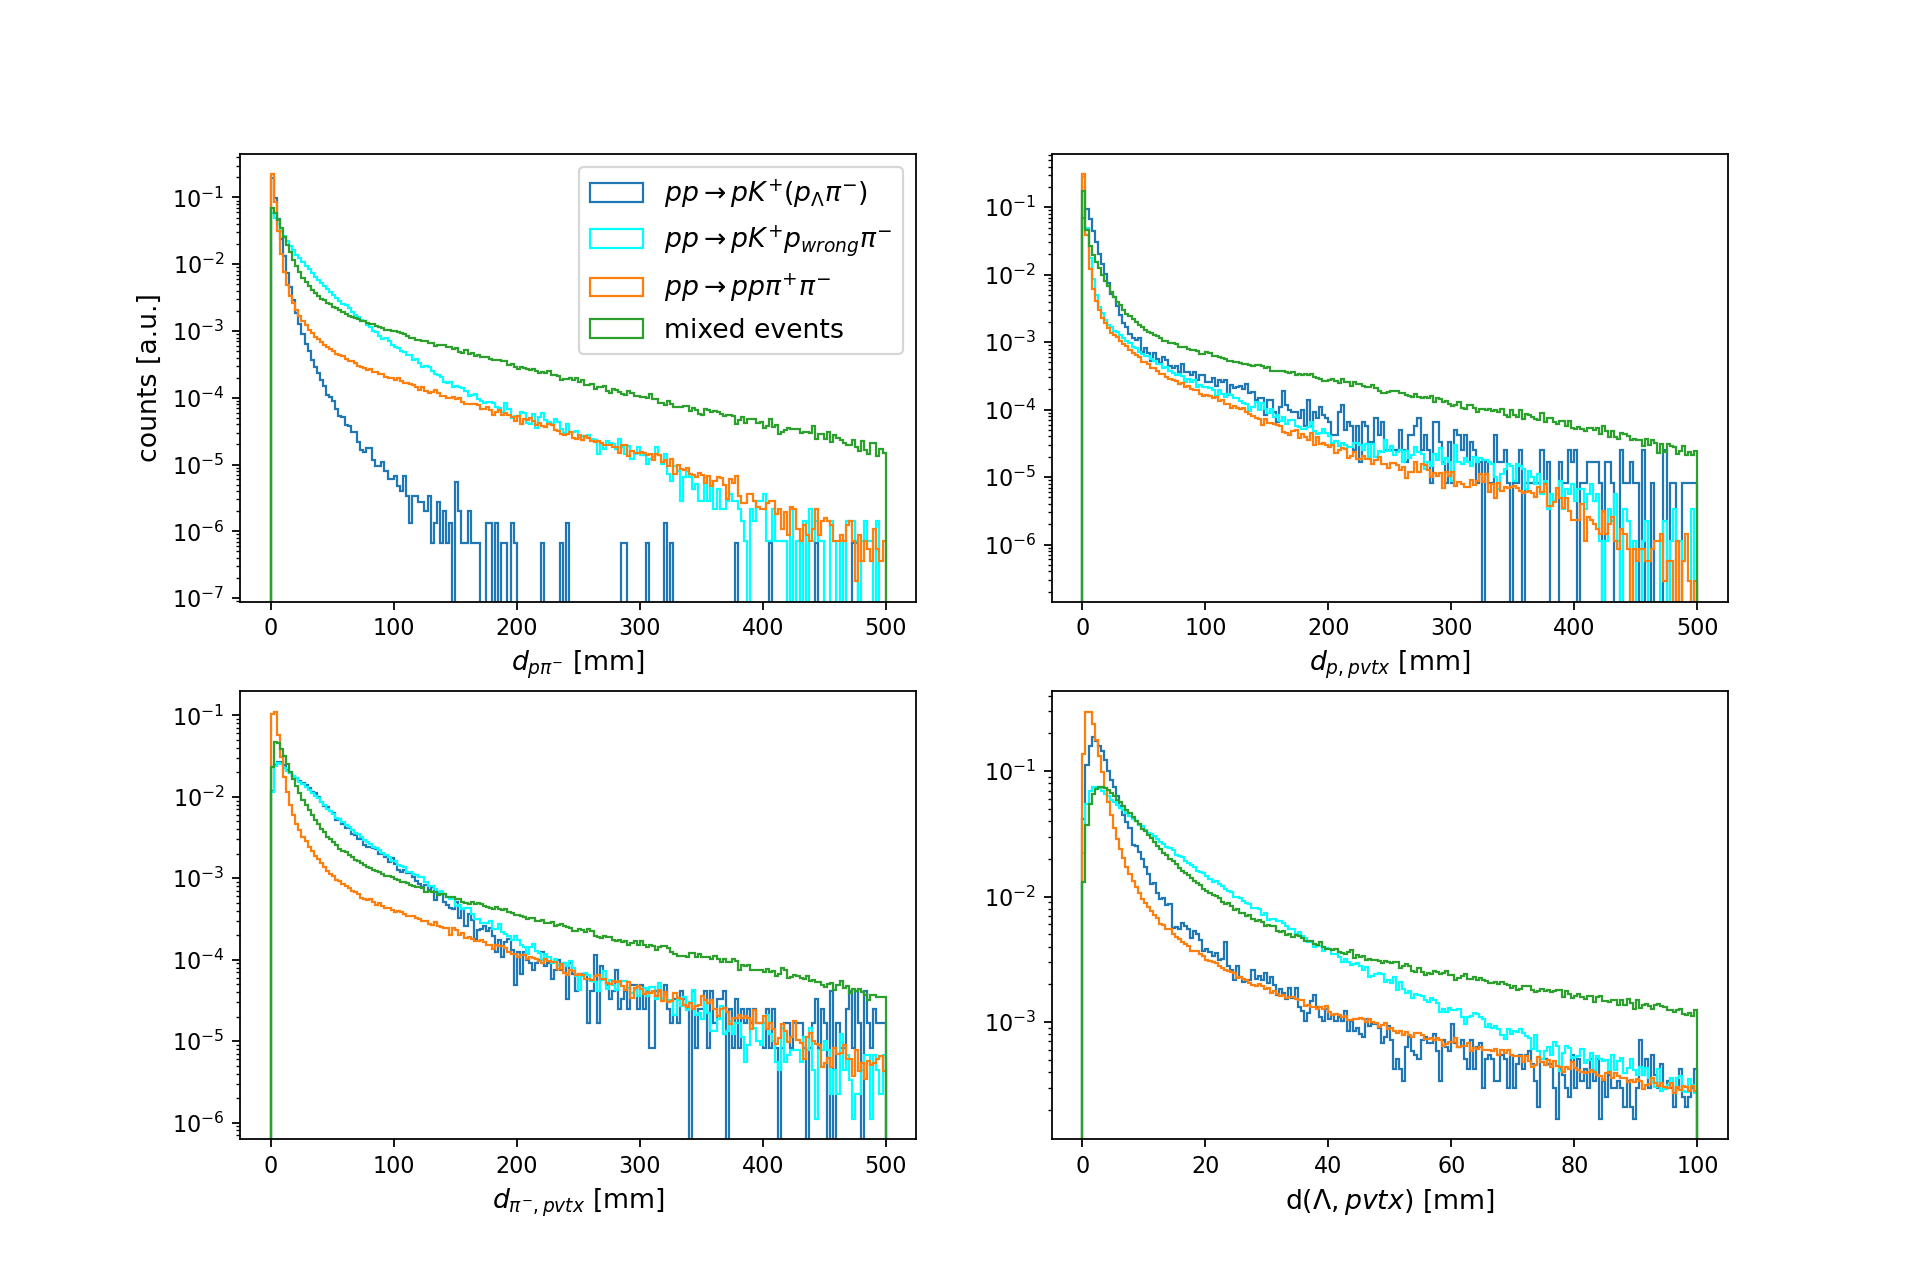

In [5]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

df = train

plt.subplot(2, 2, 1)
plt.hist(df.loc[df.label==1].d_ppi, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda} \pi^{-})$', range=(0,500), density=True)
plt.hist(df.loc[df.label==2].d_ppi, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} p_{wrong} \pi^{-}$', range=(0,500), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_ppi, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,500), density=True)
plt.hist(df.loc[df.label==-1].d_ppi, histtype='step', bins=200, label='mixed events', range=(0,500), density=True)

plt.xlabel(r'$d_{p\pi^{-}}$ [mm]', fontsize=12)
plt.ylabel('counts [a.u.]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)


plt.subplot(2, 2, 2)
plt.hist(df.loc[df.label==1].d_p_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,500), density=True)
plt.hist(df.loc[df.label==2].d_p_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,500), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_p_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,500), density=True)
plt.hist(df.loc[df.label==-1].d_p_pvtx, histtype='step', bins=200, label='mixed events', range=(0,500), density=True)
plt.xlabel(r'$d_{p, pvtx}$ [mm]', fontsize=12)
plt.semilogy()

plt.subplot(2, 2, 3)
plt.hist(df.loc[df.label==1].d_pi_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,500), density=True)
plt.hist(df.loc[df.label==2].d_pi_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,500), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_pi_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,500), density=True)
plt.hist(df.loc[df.label==-1].d_pi_pvtx, histtype='step', bins=200, label='mixed events', range=(0,500), density=True)
plt.xlabel(r'$d_{\pi^{-}, pvtx}$ [mm]', fontsize=12)
plt.semilogy()

plt.subplot(2, 2, 4)
plt.hist(df.loc[df.label==1].d_l, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,100), density=True)
plt.hist(df.loc[df.label==2].d_l, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,100), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_l, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,100), density=True)
plt.hist(df.loc[df.label==-1].d_l, histtype='step', bins=200, label='mixed events', range=(0,100), density=True)
plt.xlabel(r'd($\Lambda, pvtx$) [mm]', fontsize=12)
plt.semilogy()


plt.show()

<IPython.core.display.Javascript object>


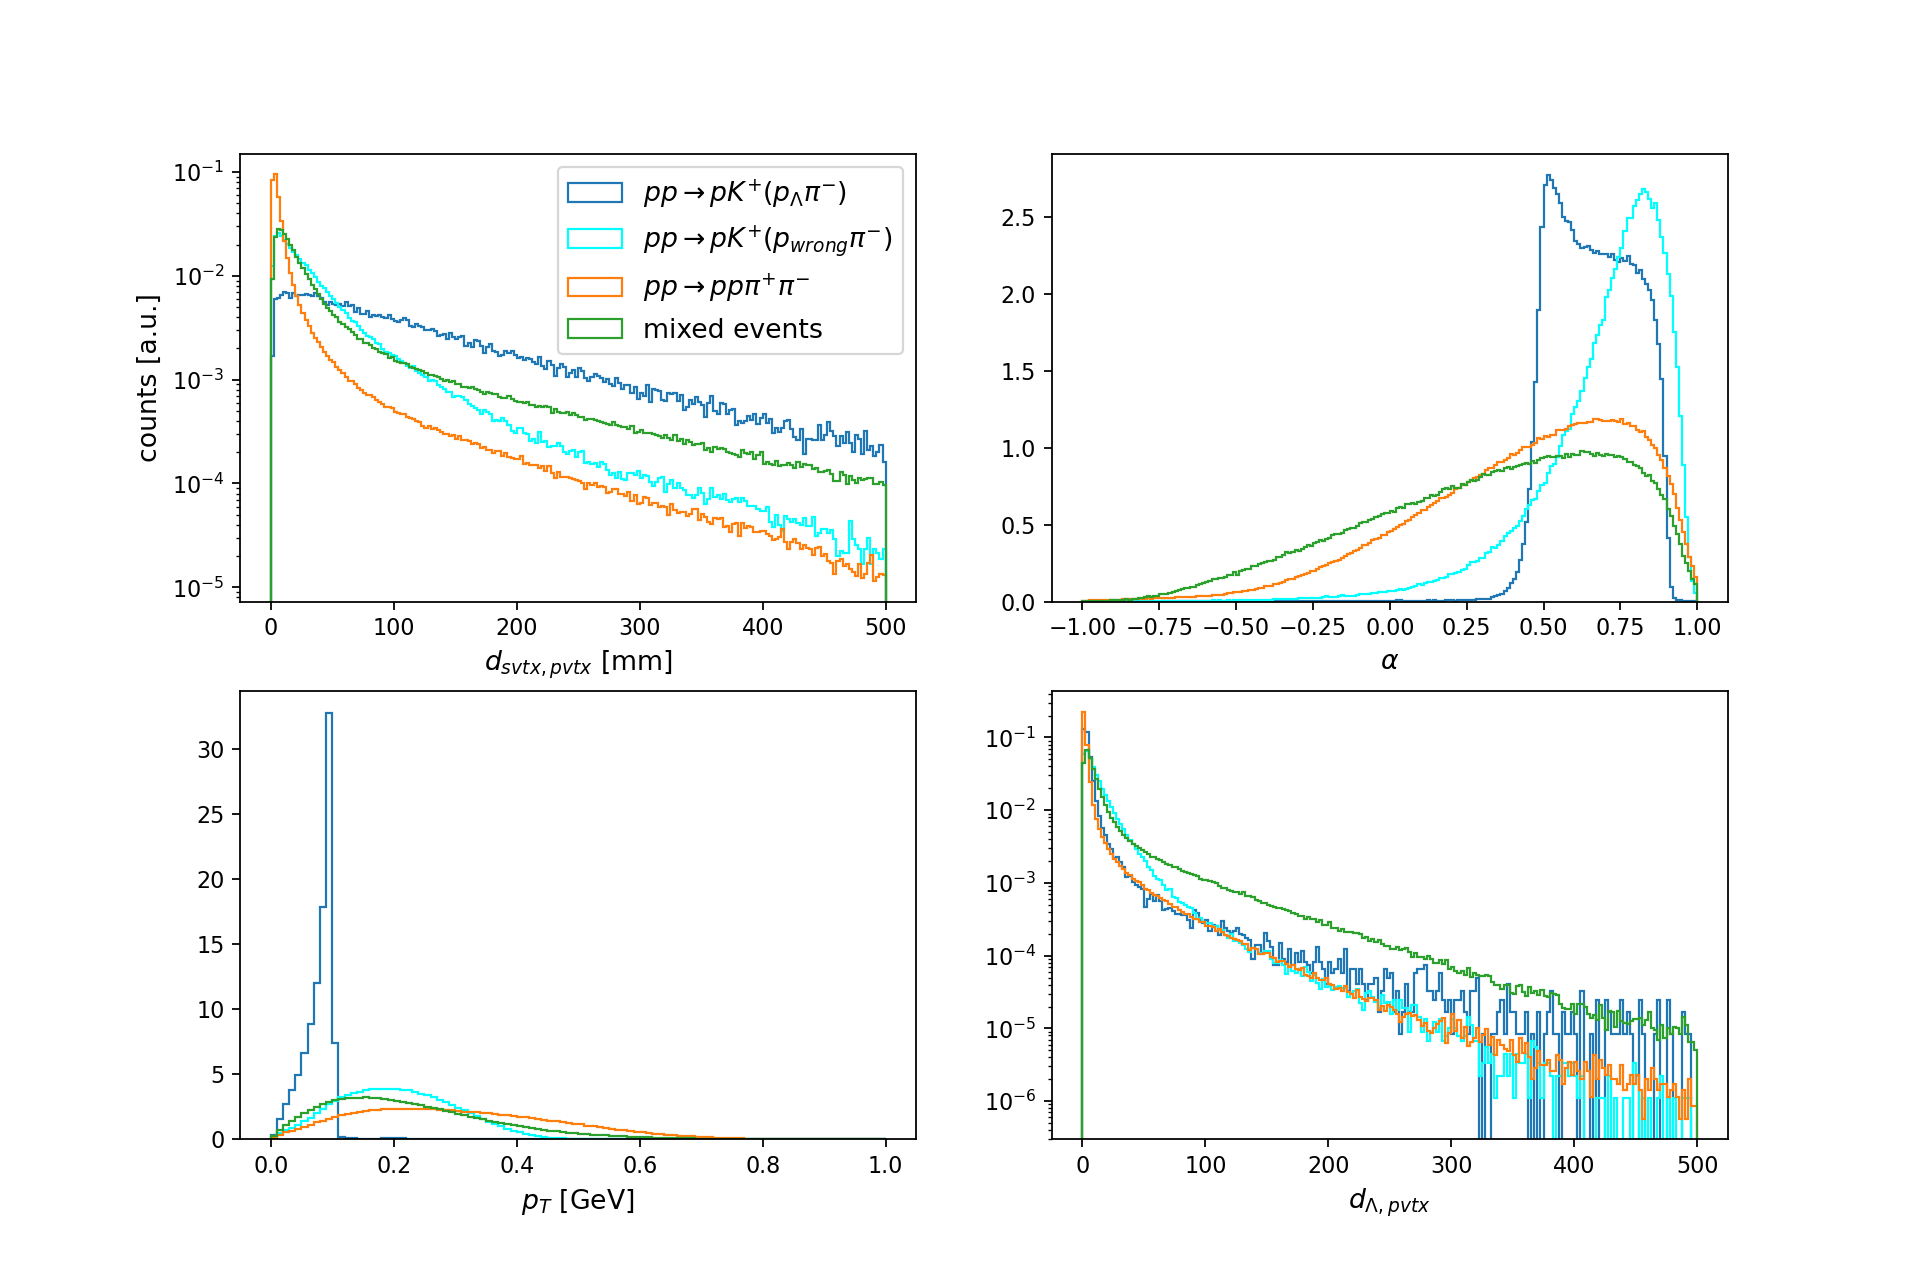

In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

plt.subplot(2, 2, 1)
plt.hist(df.loc[df.label==1].d_svtx_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,500), density=True)
plt.hist(df.loc[df.label==2].d_svtx_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,500), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_svtx_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,500), density=True)
plt.hist(df.loc[df.label==-1].d_svtx_pvtx, histtype='step', bins=200, label='mixed events', range=(0,500), density=True)
plt.xlabel(r'$d_{svtx, pvtx}$ [mm]', fontsize=12)
plt.ylabel('counts [a.u.]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

plt.subplot(2, 2, 4)
plt.hist(df.loc[df.label==1].d_l, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,500), density=True)
plt.hist(df.loc[df.label==2].d_l, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,500), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_l, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,500), density=True)
plt.hist(df.loc[df.label==-1].d_l, histtype='step', bins=200, label='mixed events', range=(0,500), density=True)
plt.semilogy()
plt.xlabel(r'$d_{\Lambda, pvtx}$', fontsize=12)


plt.subplot(2, 2, 2)
plt.hist(df.loc[df.label==1].alpha, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(-1,1), density=True)
plt.hist(df.loc[df.label==2].alpha, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(-1,1), density=True, color='cyan')
plt.hist(df.loc[df.label==0].alpha, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(-1,1), density=True)
plt.hist(df.loc[df.label==-1].alpha, histtype='step', bins=200, label='mixed events', range=(-1,1), density=True)
plt.xlabel(r'$\alpha$', fontsize=12)

plt.subplot(2, 2, 3)
plt.hist(df.loc[df.label==1].q_t, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,1), density=True)
plt.hist(df.loc[df.label==2].q_t, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,1), density=True, color='cyan')
plt.hist(df.loc[df.label==0].q_t, histtype='step', bins=100, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,1), density=True)
plt.hist(df.loc[df.label==-1].q_t, histtype='step', bins=100, label='mixed events', range=(0,1), density=True)
plt.xlabel(r'$p_{T}$ [GeV]', fontsize=12)


plt.show()

#### The Armenteros Plot for the $\Lambda$ candidates
This is a two dimensional plot, of transverse momentum $p_{T}$ of the oppositely charged decay products with respect to the $V_{0}$ (in this case $\Lambda$) versus the longitudinal momentum asymmetry $\alpha$

<IPython.core.display.Javascript object>


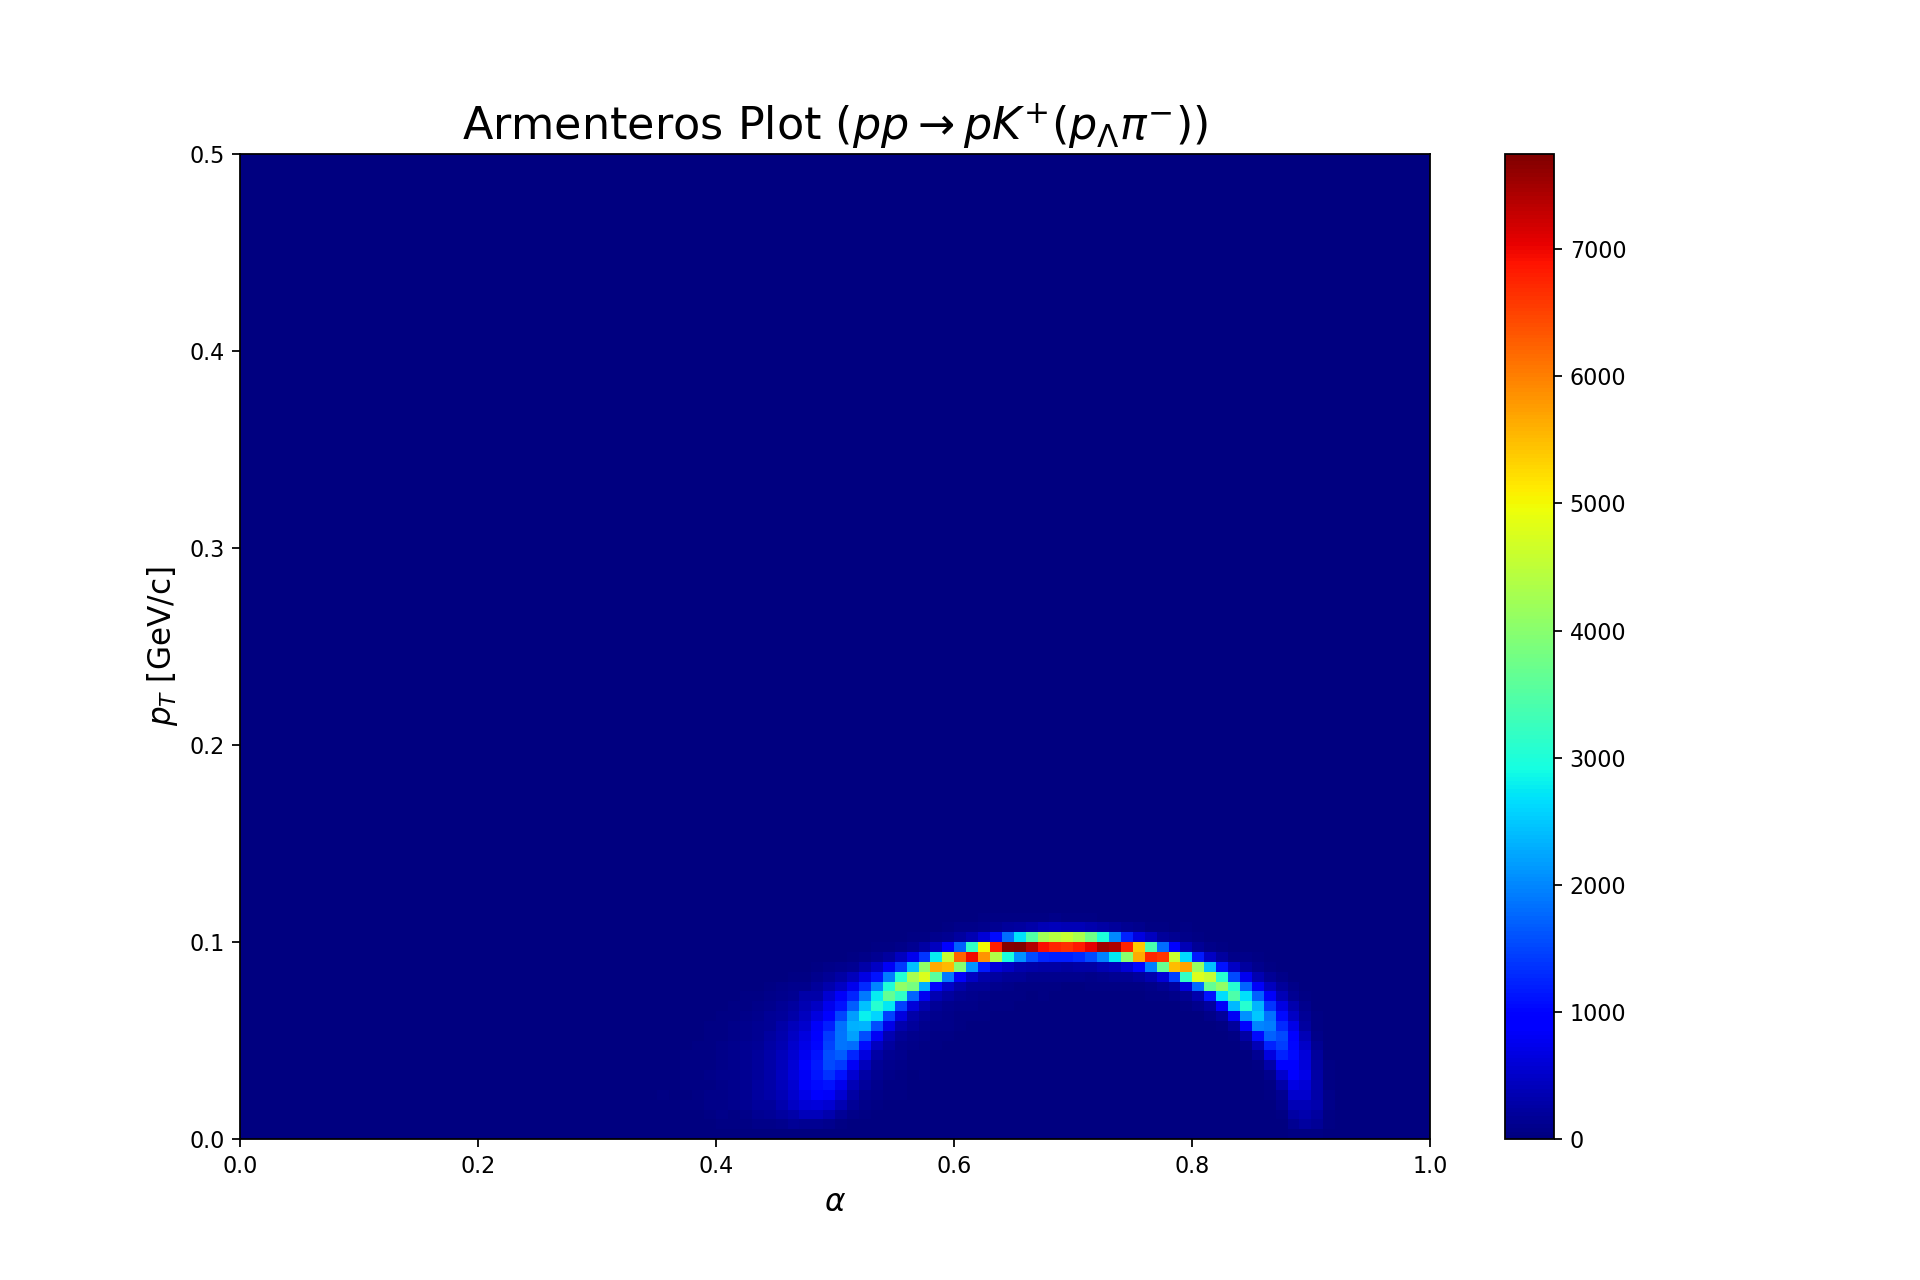

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)
_ = plt.hist2d(df.loc[df.label==1].alpha, df.loc[df.label==1].q_t, bins=(100, 100), range=[[0, 1], [0, 0.5]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title(r'Armenteros Plot ($pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$)', fontsize=20)
plt.colorbar()

<IPython.core.display.Javascript object>


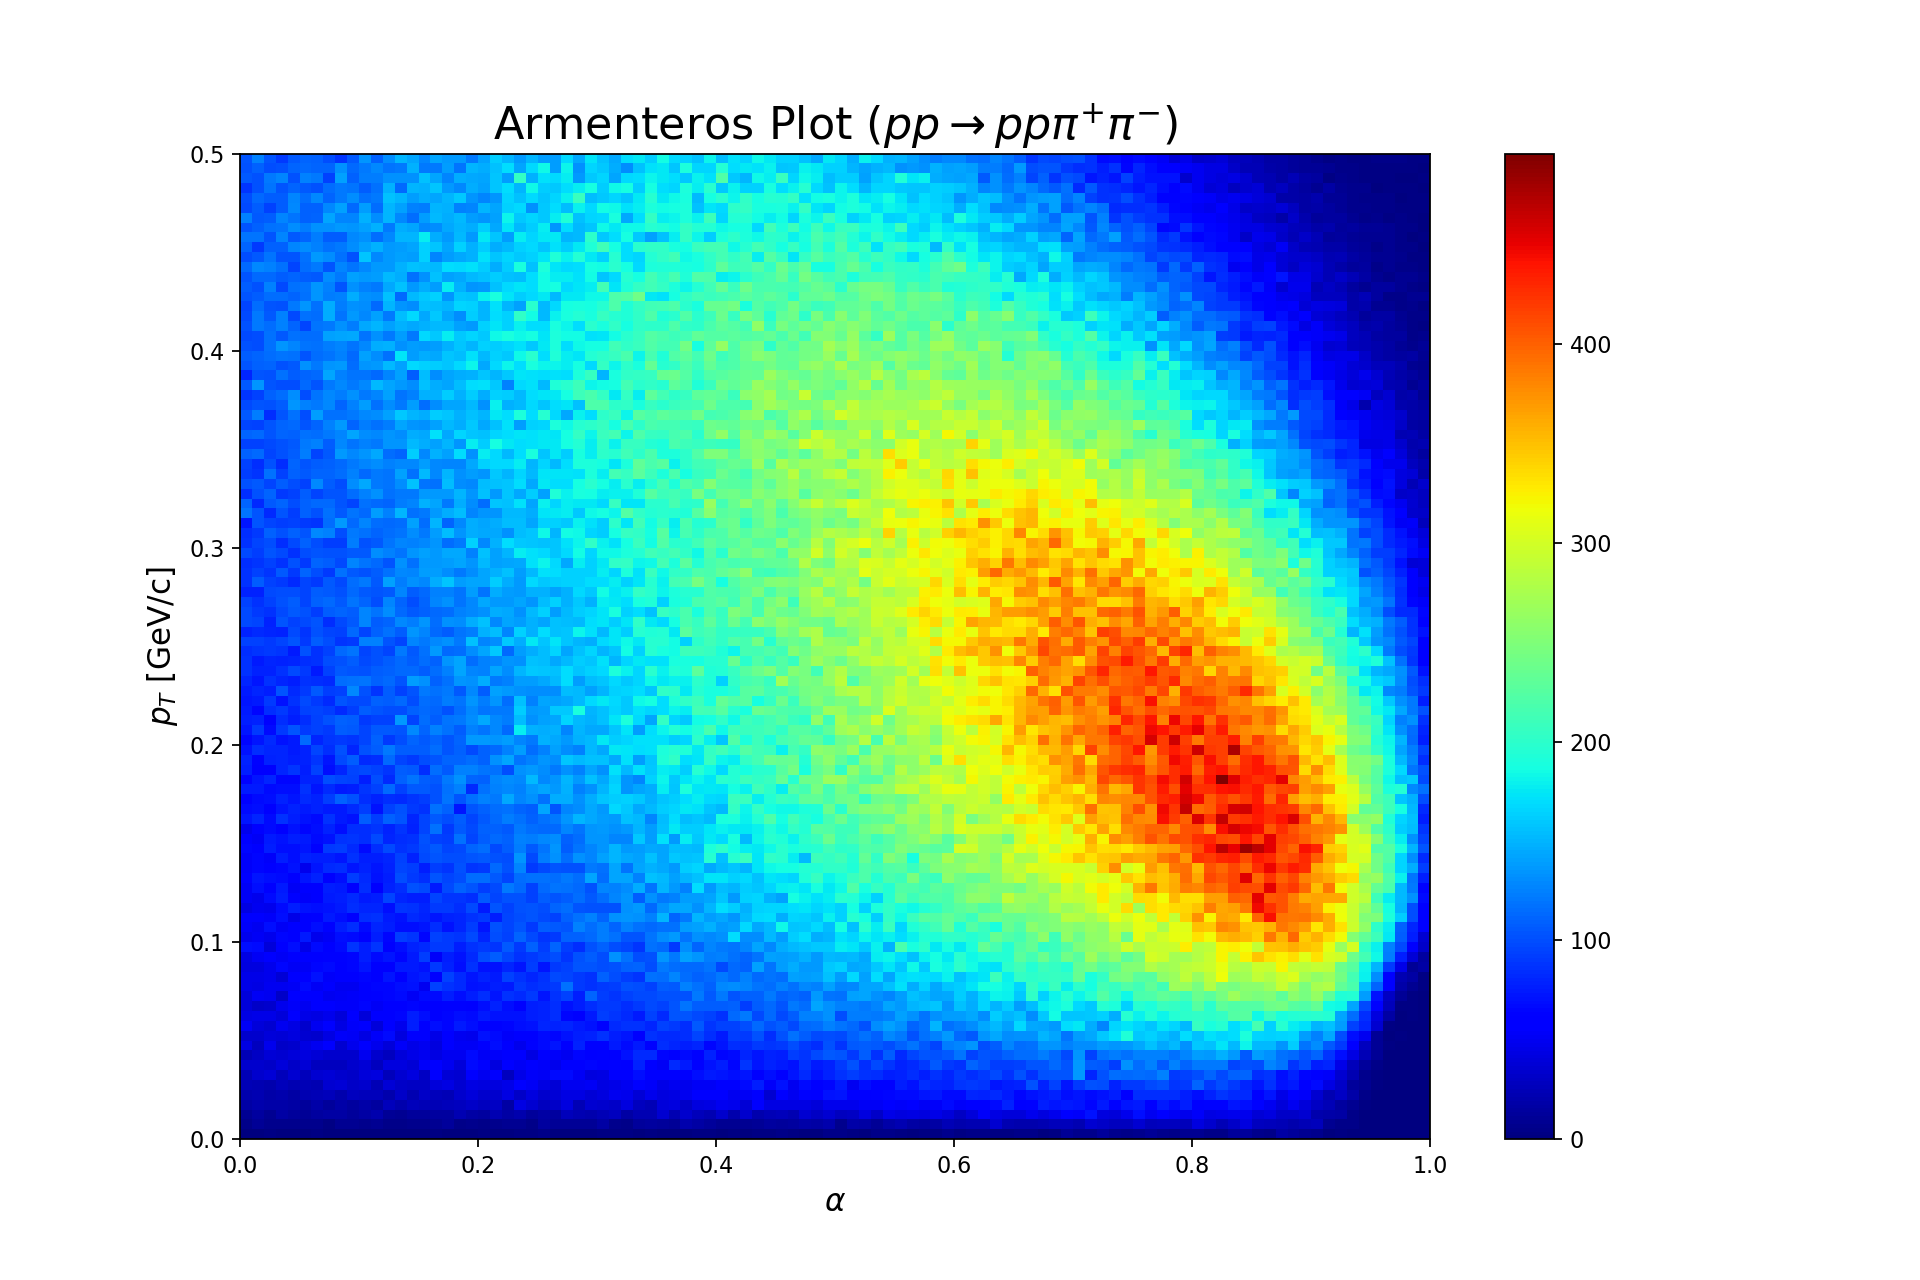

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)
_ = plt.hist2d(df.loc[df.label==0].alpha, df.loc[df.label==0].q_t, bins=(100, 100), range=[[0, 1], [0, 0.5]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title(r'Armenteros Plot ($pp \rightarrow pp \pi^{+} \pi^{-}$)', fontsize=20)
plt.colorbar()

<IPython.core.display.Javascript object>


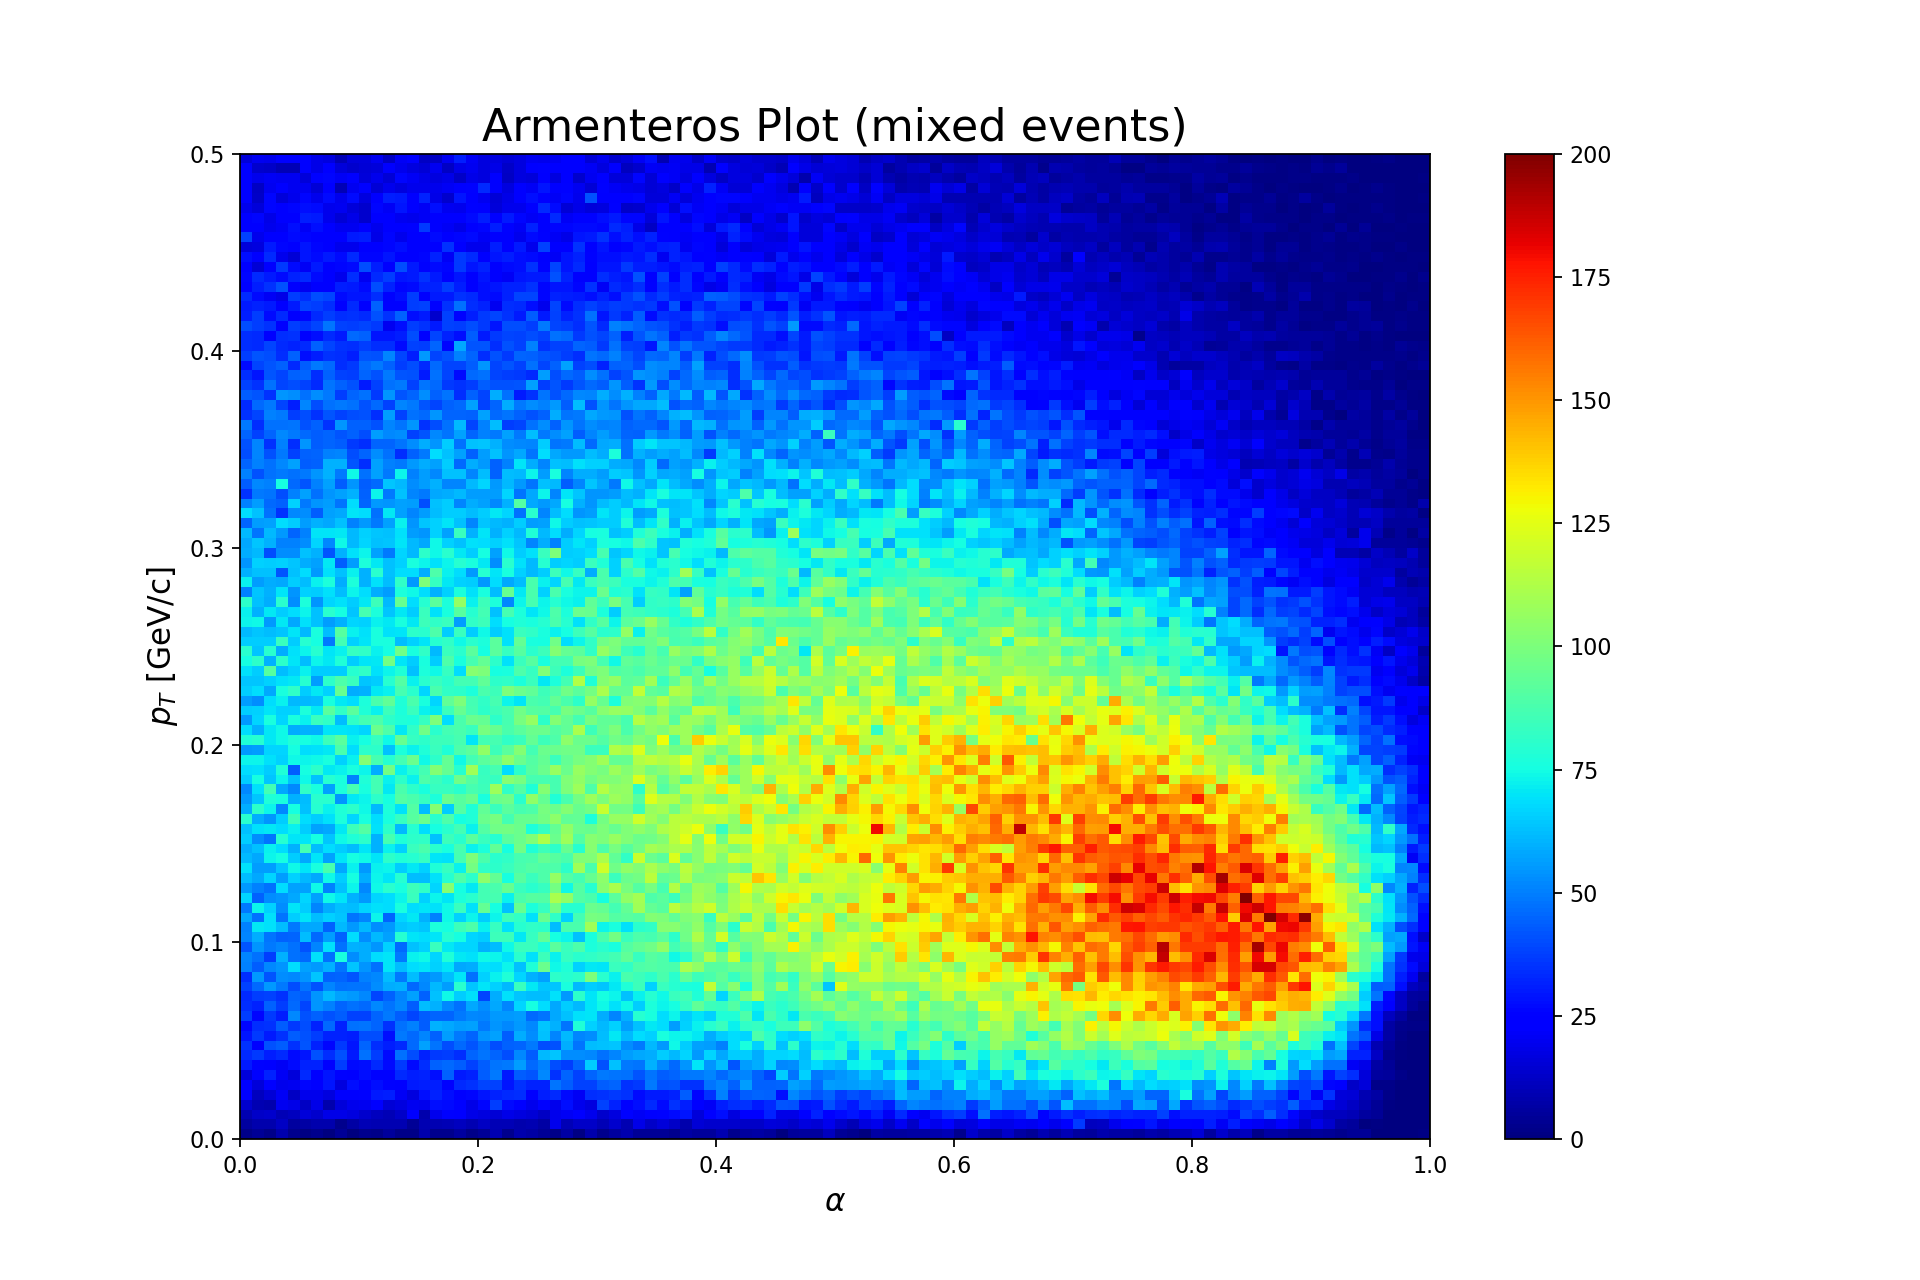

In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)
_ = plt.hist2d(df.loc[df.label==-1].alpha, df.loc[df.label==-1].q_t, bins=(100, 100), range=[[0, 1], [0, 0.5]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title(r'Armenteros Plot (mixed events)', fontsize=20)
plt.colorbar()

#### Since the kinematic distributions are obviously different as can be seen from the Armenteros plots, let us check the 4-vectors of daughter particles. 

<IPython.core.display.Javascript object>


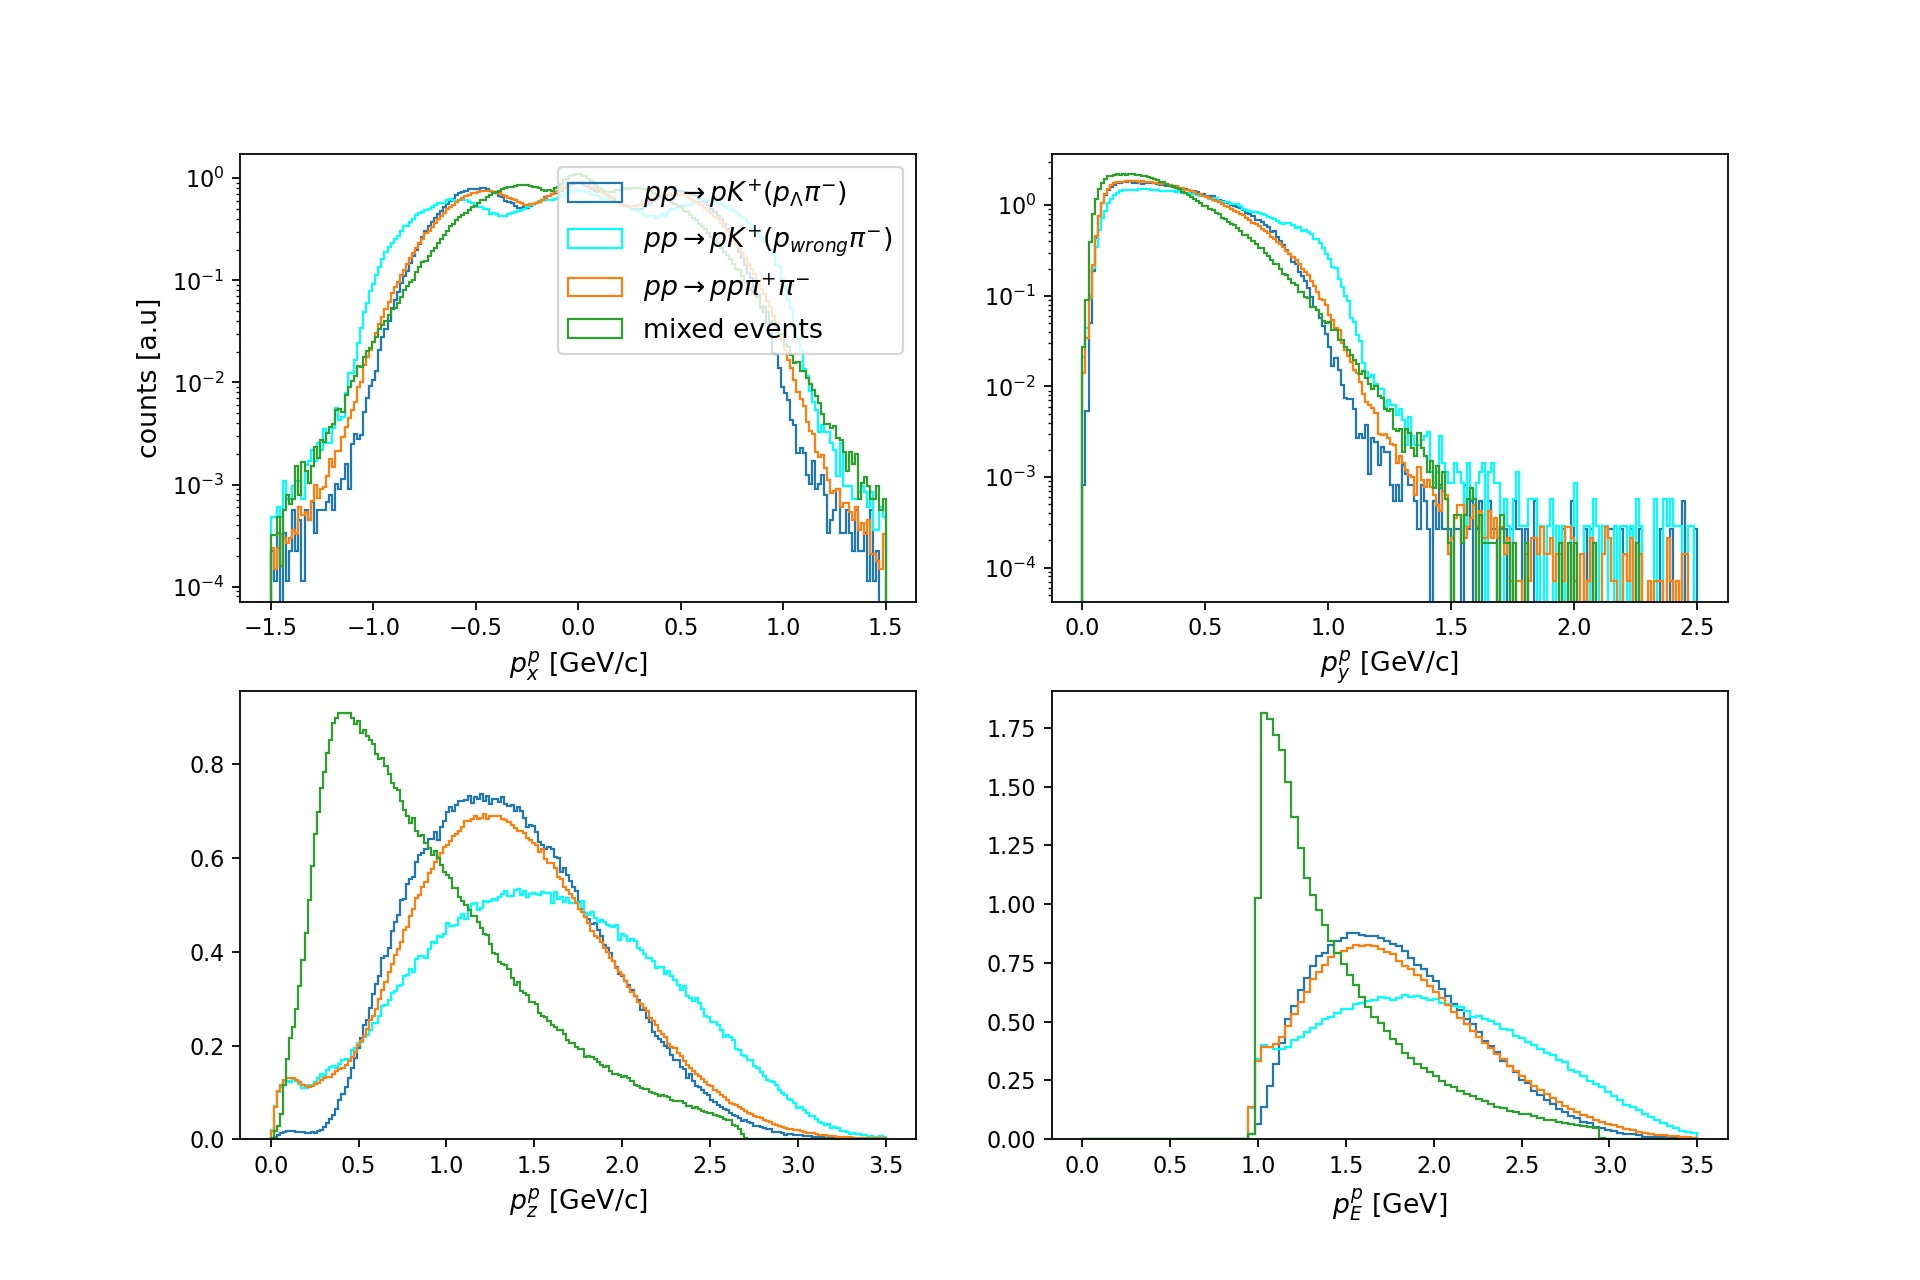

In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

ppx_range = (-1.5, 1.5)
plt.subplot(2, 2, 1)
plt.hist(df.loc[df.label==1].ppx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppx_range, density=True)
plt.hist(df.loc[df.label==2].ppx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppx_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].ppx, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppx_range, density=True)
plt.hist(df.loc[df.label==-1].ppx, histtype='step', bins=200, label='mixed events', range=ppx_range, density=True)
plt.xlabel(r'$p^{p}_{x}$ [GeV/c]', fontsize=12)
plt.ylabel('counts [a.u]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

ppy_range = (0, 2.5)
plt.subplot(2, 2, 2)
plt.hist(df.loc[df.label==1].ppy, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppy_range, density=True)
plt.hist(df.loc[df.label==2].ppy, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppy_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].ppy, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppy_range, density=True)
plt.hist(df.loc[df.label==-1].ppy, histtype='step', bins=200, label='mixed events', range=ppy_range, density=True)
plt.semilogy()
plt.xlabel(r'$p^{p}_{y}$ [GeV/c]', fontsize=12)

ppz_range = (0, 3.5)
plt.subplot(2, 2, 3)
plt.hist(df.loc[df.label==1].ppz, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppz_range, density=True)
plt.hist(df.loc[df.label==2].ppz, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppz_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].ppz, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppz_range, density=True)
plt.hist(df.loc[df.label==-1].ppz, histtype='step', bins=200, label='mixed events', range=ppz_range, density=True)
plt.xlabel(r'$p^{p}_{z}$ [GeV/c]', fontsize=12)

ppe_range = (0, 3.5)
plt.subplot(2, 2, 4)
plt.hist(df.loc[df.label==1].pe, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppe_range, density=True)
plt.hist(df.loc[df.label==2].pe, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppe_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].pe, histtype='step', bins=100, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppe_range, density=True)
plt.hist(df.loc[df.label==-1].pe, histtype='step', bins=100, label='mixed events', range=ppe_range, density=True)
plt.xlabel(r'$p^{p}_{E}$ [GeV]', fontsize=12)


plt.show()

<IPython.core.display.Javascript object>


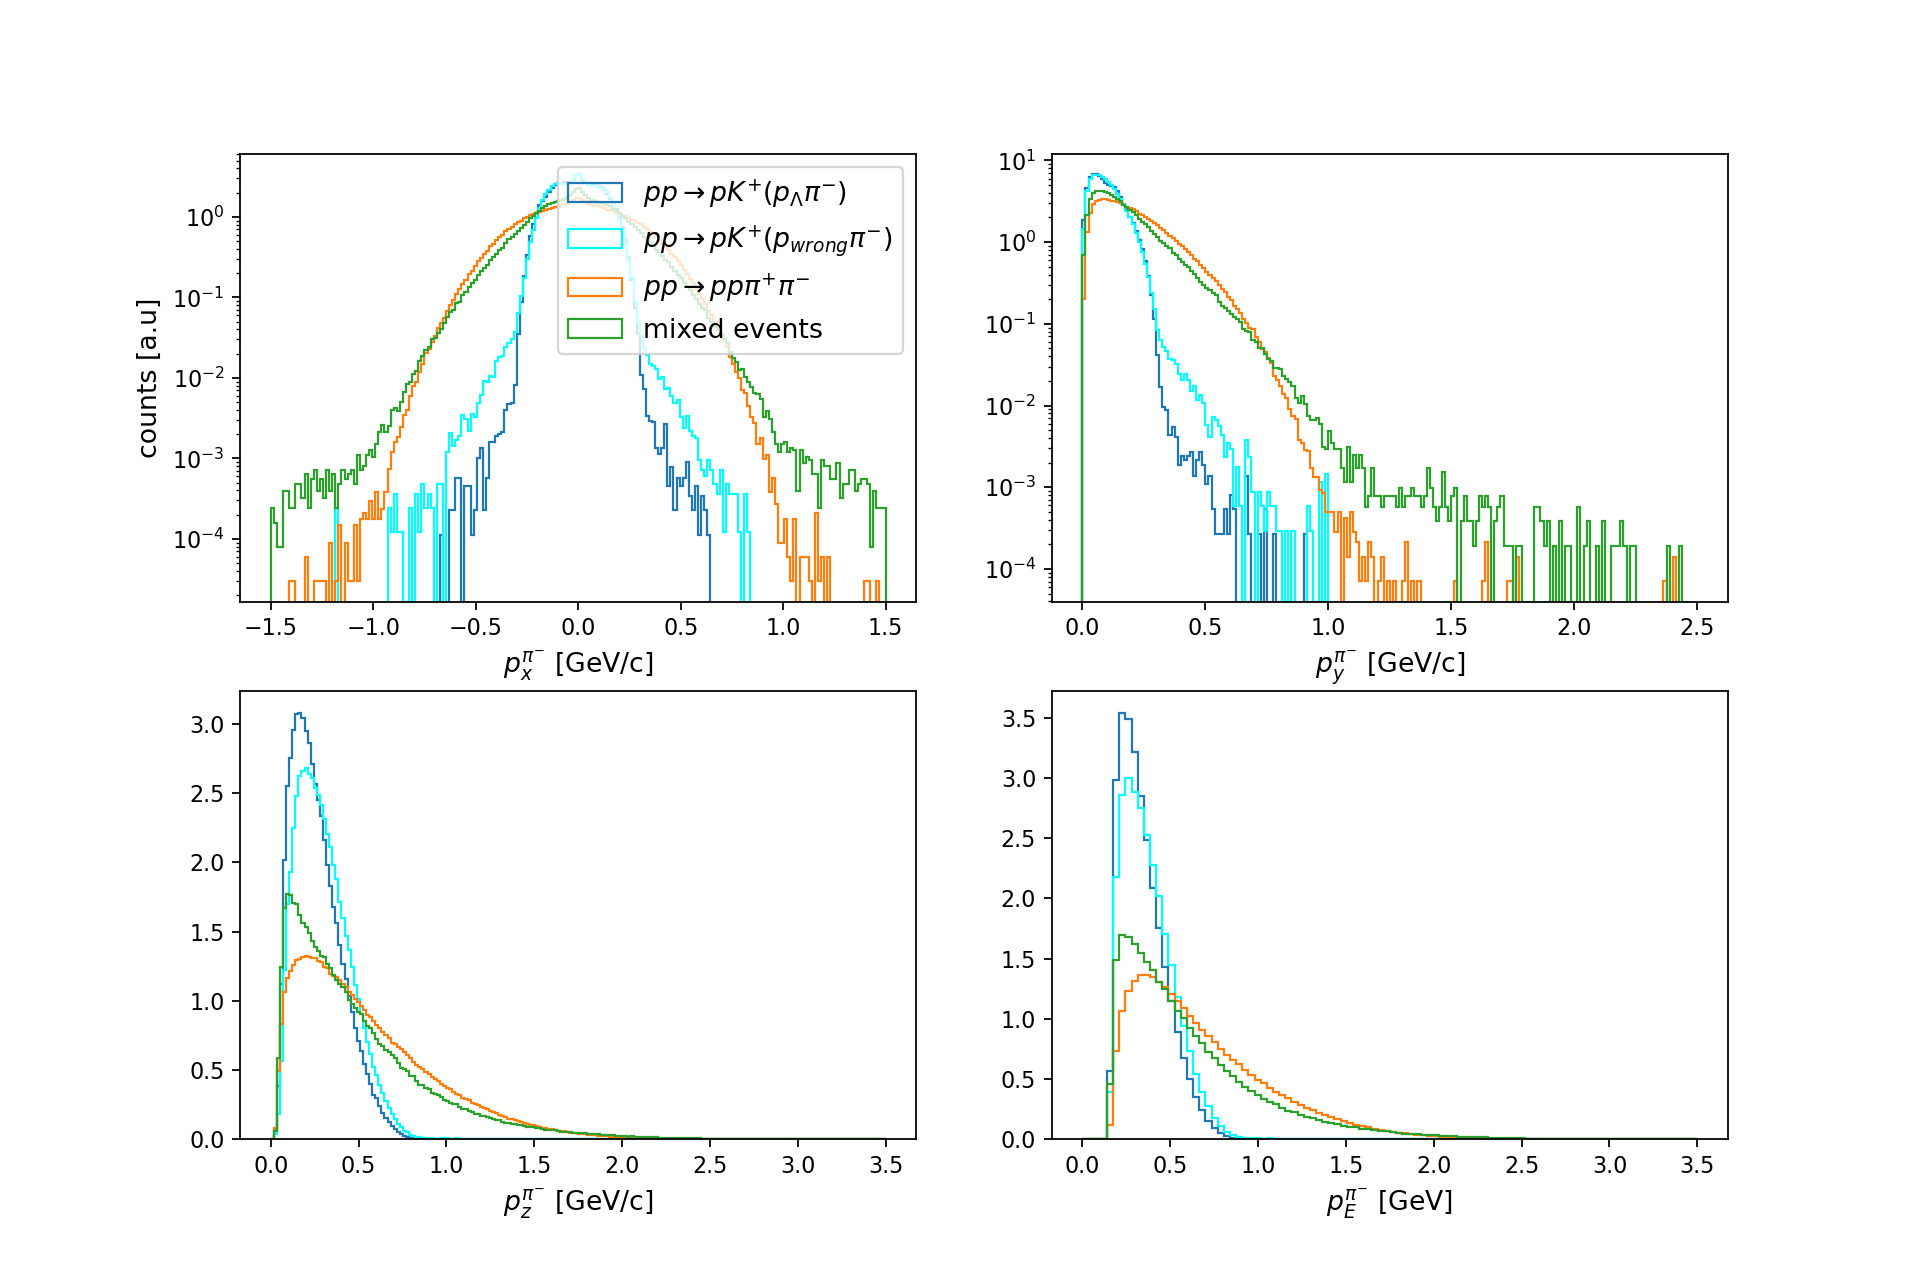

In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

ppx_range = (-1.5, 1.5)
plt.subplot(2, 2, 1)
plt.hist(df.loc[df.label==1].pipx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppx_range, density=True)
plt.hist(df.loc[df.label==2].pipx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppx_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].pipx, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppx_range, density=True)
plt.hist(df.loc[df.label==-1].pipx, histtype='step', bins=200, label='mixed events', range=ppx_range, density=True)
plt.xlabel(r'$p^{\pi^{-}}_{x}$ [GeV/c]', fontsize=12)
plt.ylabel('counts [a.u]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

ppy_range = (0, 2.5)
plt.subplot(2, 2, 2)
plt.hist(df.loc[df.label==1].pipy, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppy_range, density=True)
plt.hist(df.loc[df.label==2].pipy, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppy_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].pipy, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppy_range, density=True)
plt.hist(df.loc[df.label==-1].pipy, histtype='step', bins=200, label='mixed events', range=ppy_range, density=True)
plt.semilogy()
plt.xlabel(r'$p^{\pi^{-}}_{y}$ [GeV/c]', fontsize=12)

ppz_range = (0, 3.5)
plt.subplot(2, 2, 3)
plt.hist(df.loc[df.label==1].pipz, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppz_range, density=True)
plt.hist(df.loc[df.label==2].pipz, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppz_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].pipz, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppz_range, density=True)
plt.hist(df.loc[df.label==-1].pipz, histtype='step', bins=200, label='mixed events', range=ppz_range, density=True)
plt.xlabel(r'$p^{\pi^{-}}_{z}$ [GeV/c]', fontsize=12)

ppe_range = (0, 3.5)
plt.subplot(2, 2, 4)
plt.hist(df.loc[df.label==1].pie, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppe_range, density=True)
plt.hist(df.loc[df.label==2].pie, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppe_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].pie, histtype='step', bins=100, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppe_range, density=True)
plt.hist(df.loc[df.label==-1].pie, histtype='step', bins=100, label='mixed events', range=ppe_range, density=True)
plt.xlabel(r'$p^{\pi^{-}}_{E}$ [GeV]', fontsize=12)


plt.show()

#### Now, reconstruct $\Lambda$ in each event and mix only PRIMARY protons in event <font color='red'>$i$</font> with pions in event <font color='blue'>$j$</font> and PRIMARY protons in event <font color='blue'>$j$</font> with pions in event <font color='red'>$i$</font>. This sample is shown by the <font color='red'>red histogram</font>  with the label 'mixed event (kinematics)'

<IPython.core.display.Javascript object>


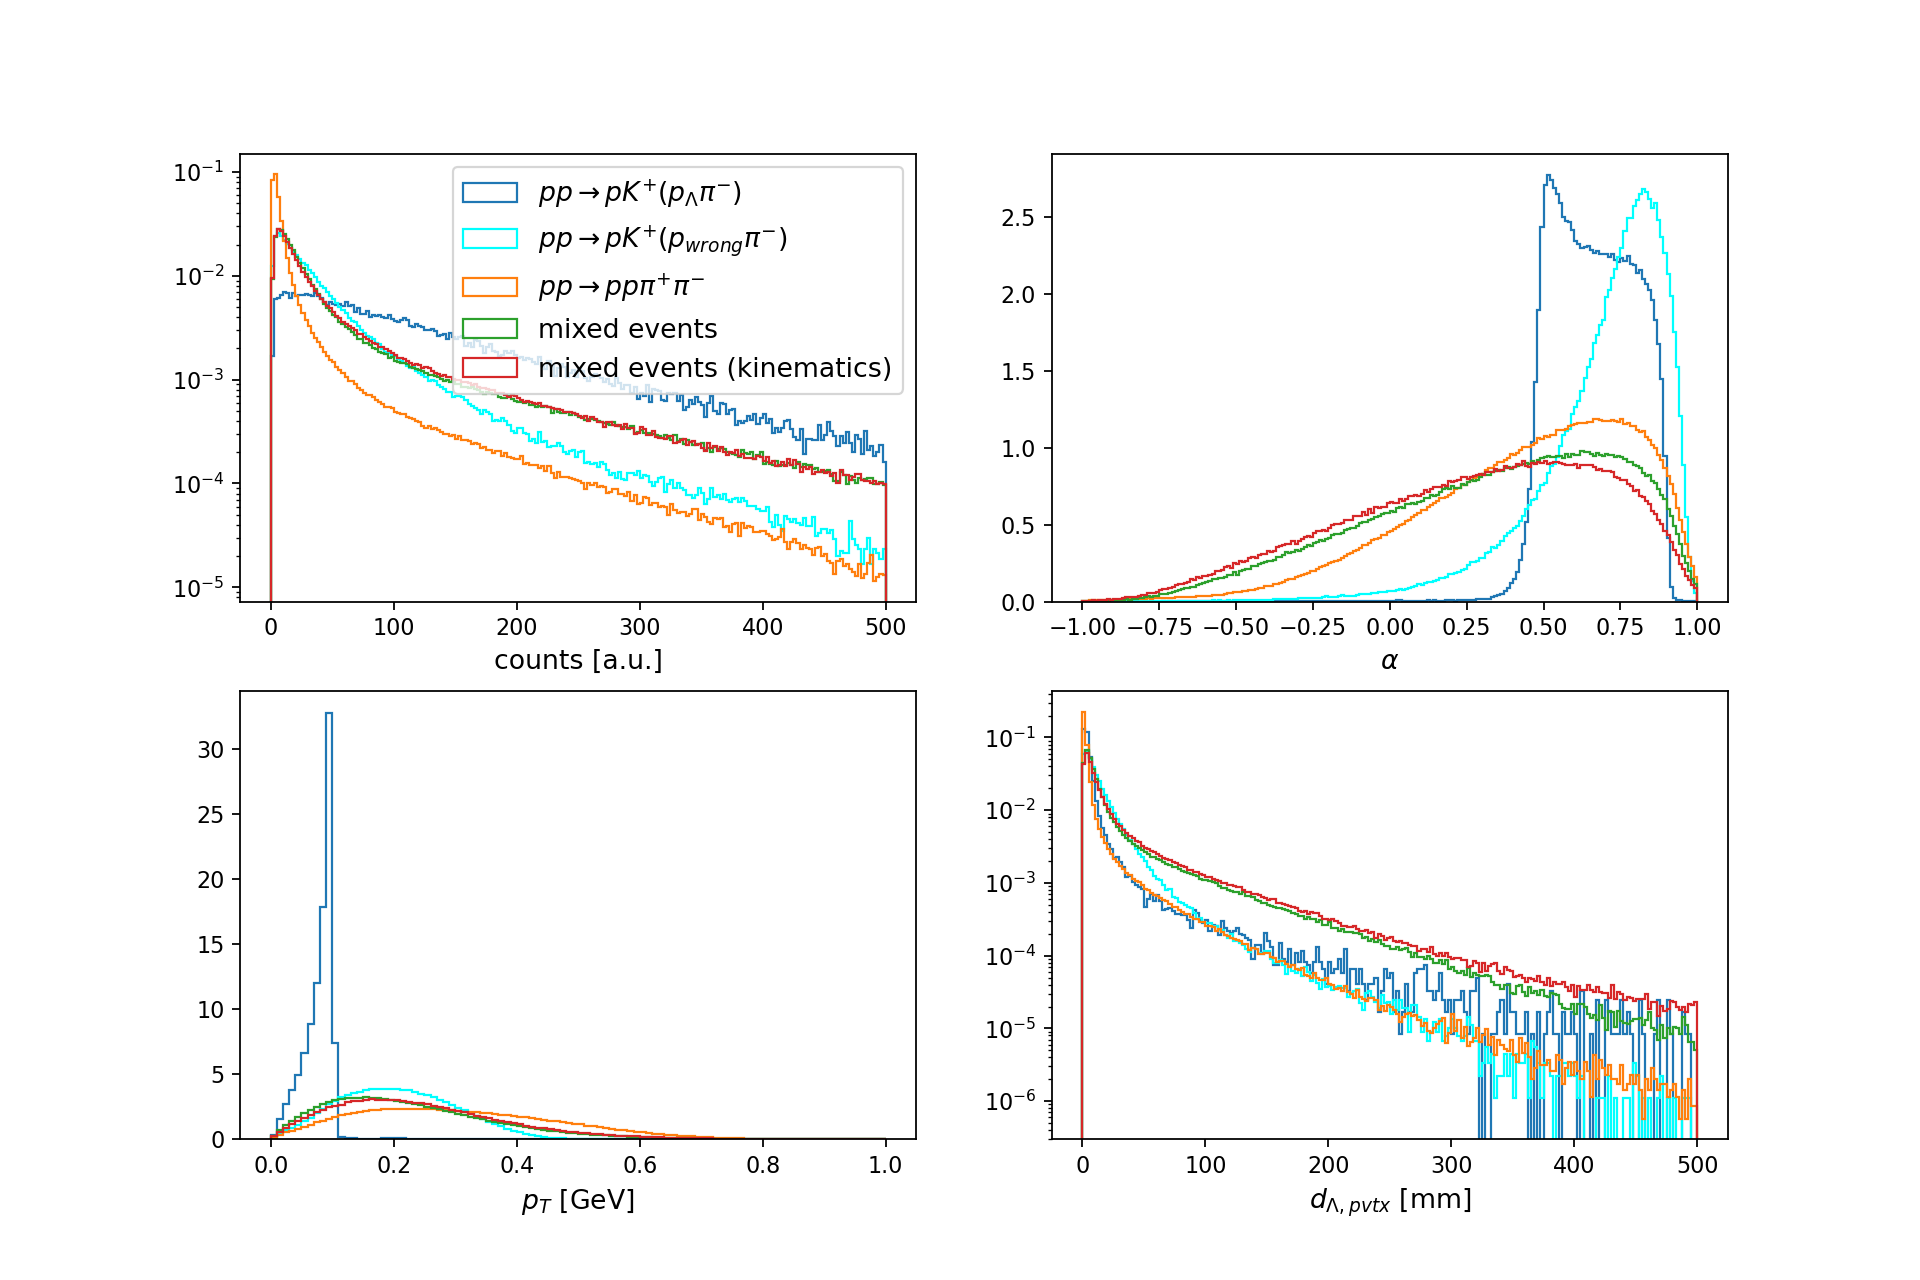

In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

plt.subplot(2, 2, 1)
plt.hist(df.loc[df.label==1].d_svtx_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,500), density=True)
plt.hist(df.loc[df.label==2].d_svtx_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,500), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_svtx_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,500), density=True)
plt.hist(df.loc[df.label==-1].d_svtx_pvtx, histtype='step', bins=200, label='mixed events', range=(0,500), density=True)
plt.hist(df.loc[df.label==-2].d_svtx_pvtx, histtype='step', bins=200, label='mixed events (kinematics)', range=(0,500), density=True)
plt.xlabel(r'$d_{svtx, pvtx}$ [mm]', fontsize=12)
plt.xlabel(r'counts [a.u.]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

plt.subplot(2, 2, 4)
plt.hist(df.loc[df.label==1].d_l, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,500), density=True)
plt.hist(df.loc[df.label==2].d_l, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,500), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_l, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,500), density=True)
plt.hist(df.loc[df.label==-1].d_l, histtype='step', bins=200, label='mixed events', range=(0,500), density=True)
plt.hist(df.loc[df.label==-2].d_l, histtype='step', bins=200, label='mixed events (kinematics)', range=(0,500), density=True)
plt.semilogy()
plt.xlabel(r'$d_{\Lambda, pvtx}$ [mm]', fontsize=12)


plt.subplot(2, 2, 2)
plt.hist(df.loc[df.label==1].alpha, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(-1,1), density=True)
plt.hist(df.loc[df.label==2].alpha, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(-1,1), density=True, color='cyan')
plt.hist(df.loc[df.label==0].alpha, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(-1,1), density=True)
plt.hist(df.loc[df.label==-1].alpha, histtype='step', bins=200, label='mixed events', range=(-1,1), density=True)
plt.hist(df.loc[df.label==-2].alpha, histtype='step', bins=200, label='mixed events (kinematics)', range=(-1,1), density=True)
plt.xlabel(r'$\alpha$', fontsize=12)

plt.subplot(2, 2, 3)
plt.hist(df.loc[df.label==1].q_t, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,1), density=True)
plt.hist(df.loc[df.label==2].q_t, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,1), density=True, color='cyan')
plt.hist(df.loc[df.label==0].q_t, histtype='step', bins=100, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,1), density=True)
plt.hist(df.loc[df.label==-1].q_t, histtype='step', bins=100, label='mixed events', range=(0,1), density=True)
plt.hist(df.loc[df.label==-2].q_t, histtype='step', bins=100, label='mixed events (kinematics)', range=(0,1), density=True)
plt.xlabel(r'$p_{T}$ [GeV]', fontsize=12)


plt.show()

<IPython.core.display.Javascript object>


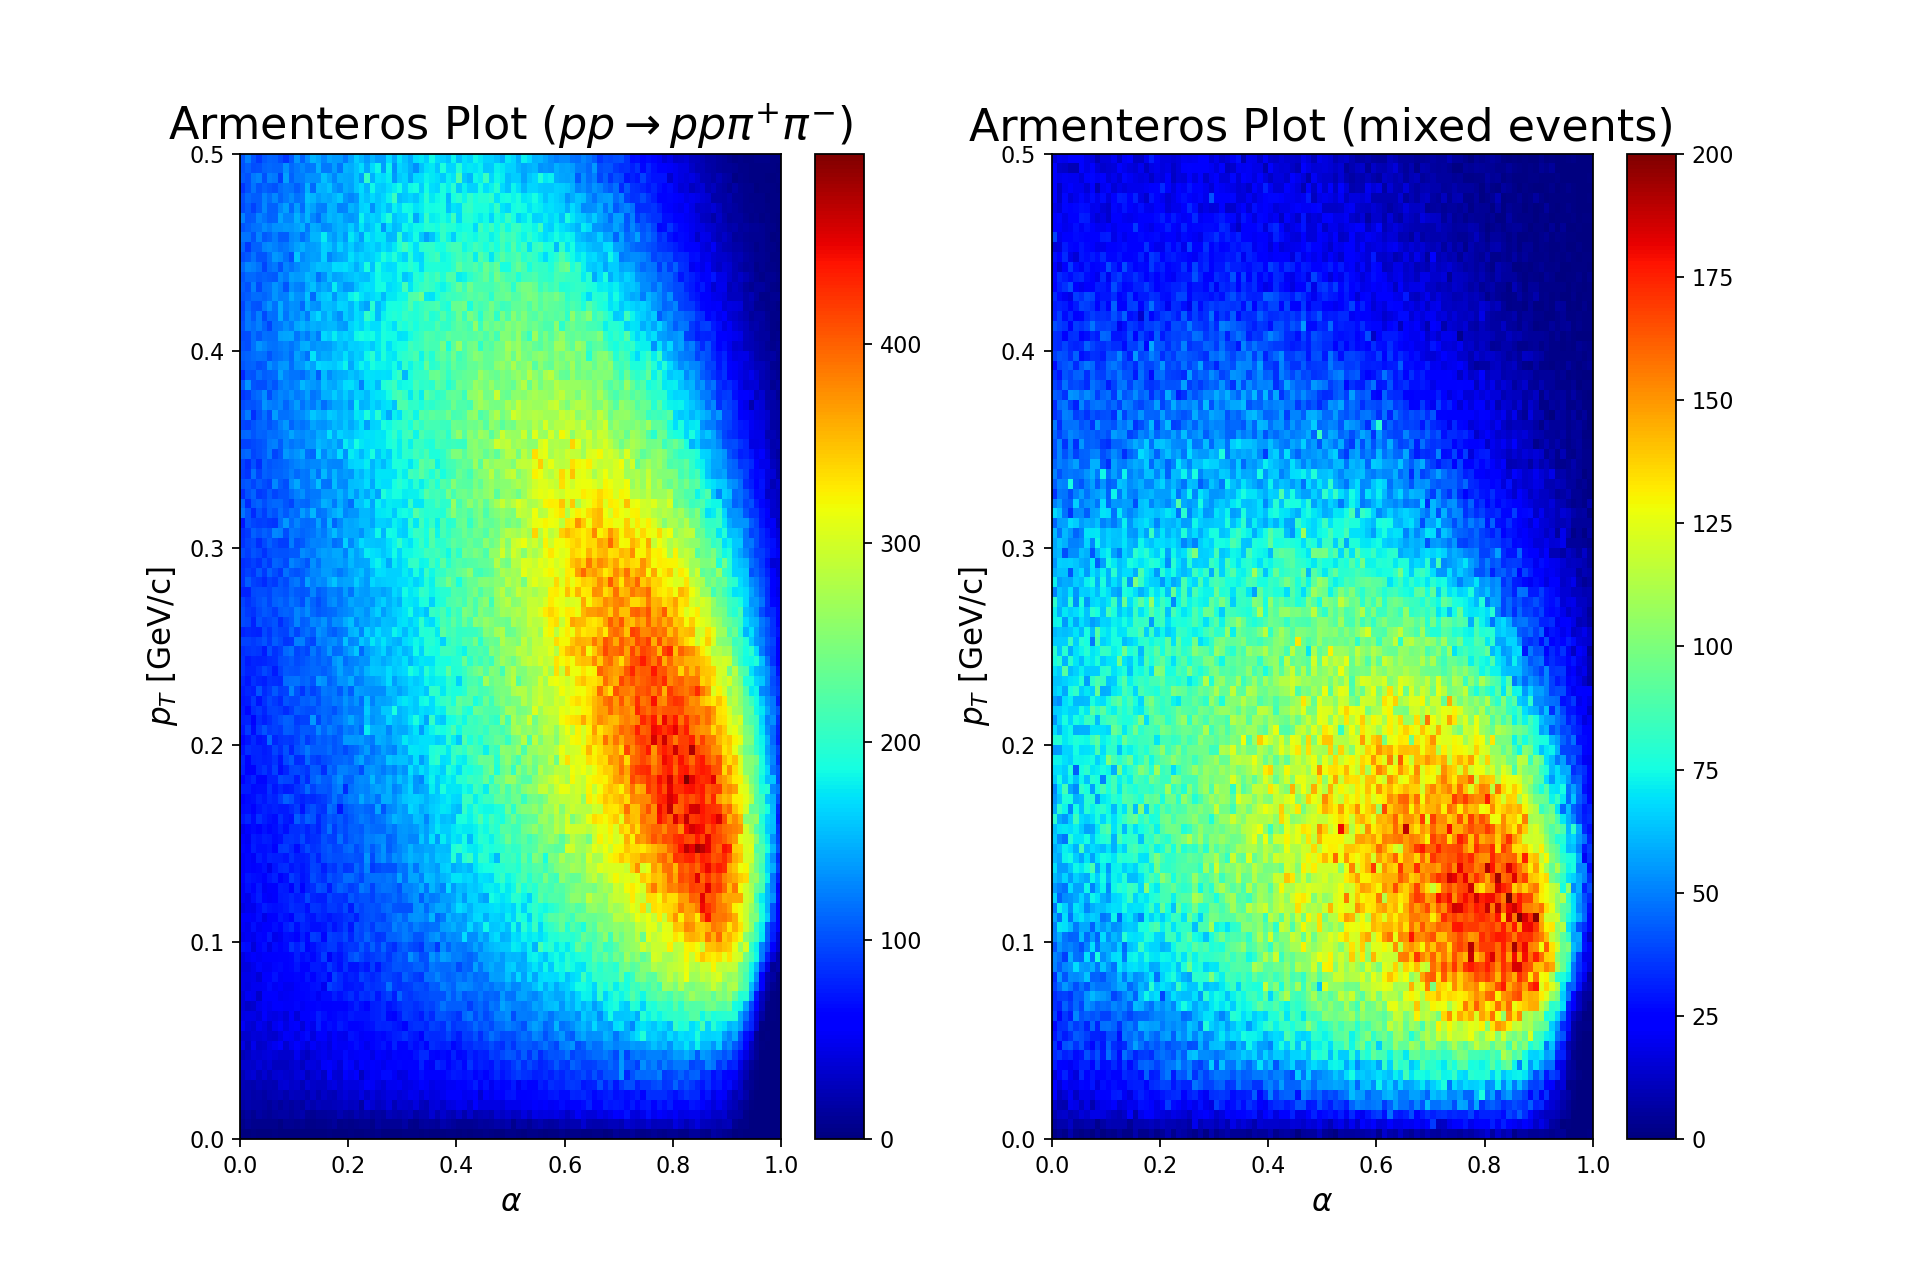

In [13]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

plt.subplot(1, 2, 1)
_ = plt.hist2d(df.loc[df.label==0].alpha, df.loc[df.label==0].q_t, bins=(100, 100), range=[[0, 1], [0, 0.5]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title(r'Armenteros Plot ($pp \rightarrow pp \pi^{+} \pi^{-}$)', fontsize=20)
plt.colorbar()


plt.subplot(1, 2, 2)
_ = plt.hist2d(df.loc[df.label==-1].alpha, df.loc[df.label==-1].q_t, bins=(100, 100), range=[[0, 1], [0, 0.5]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title(r'Armenteros Plot (mixed events)', fontsize=20)
plt.colorbar()

<IPython.core.display.Javascript object>


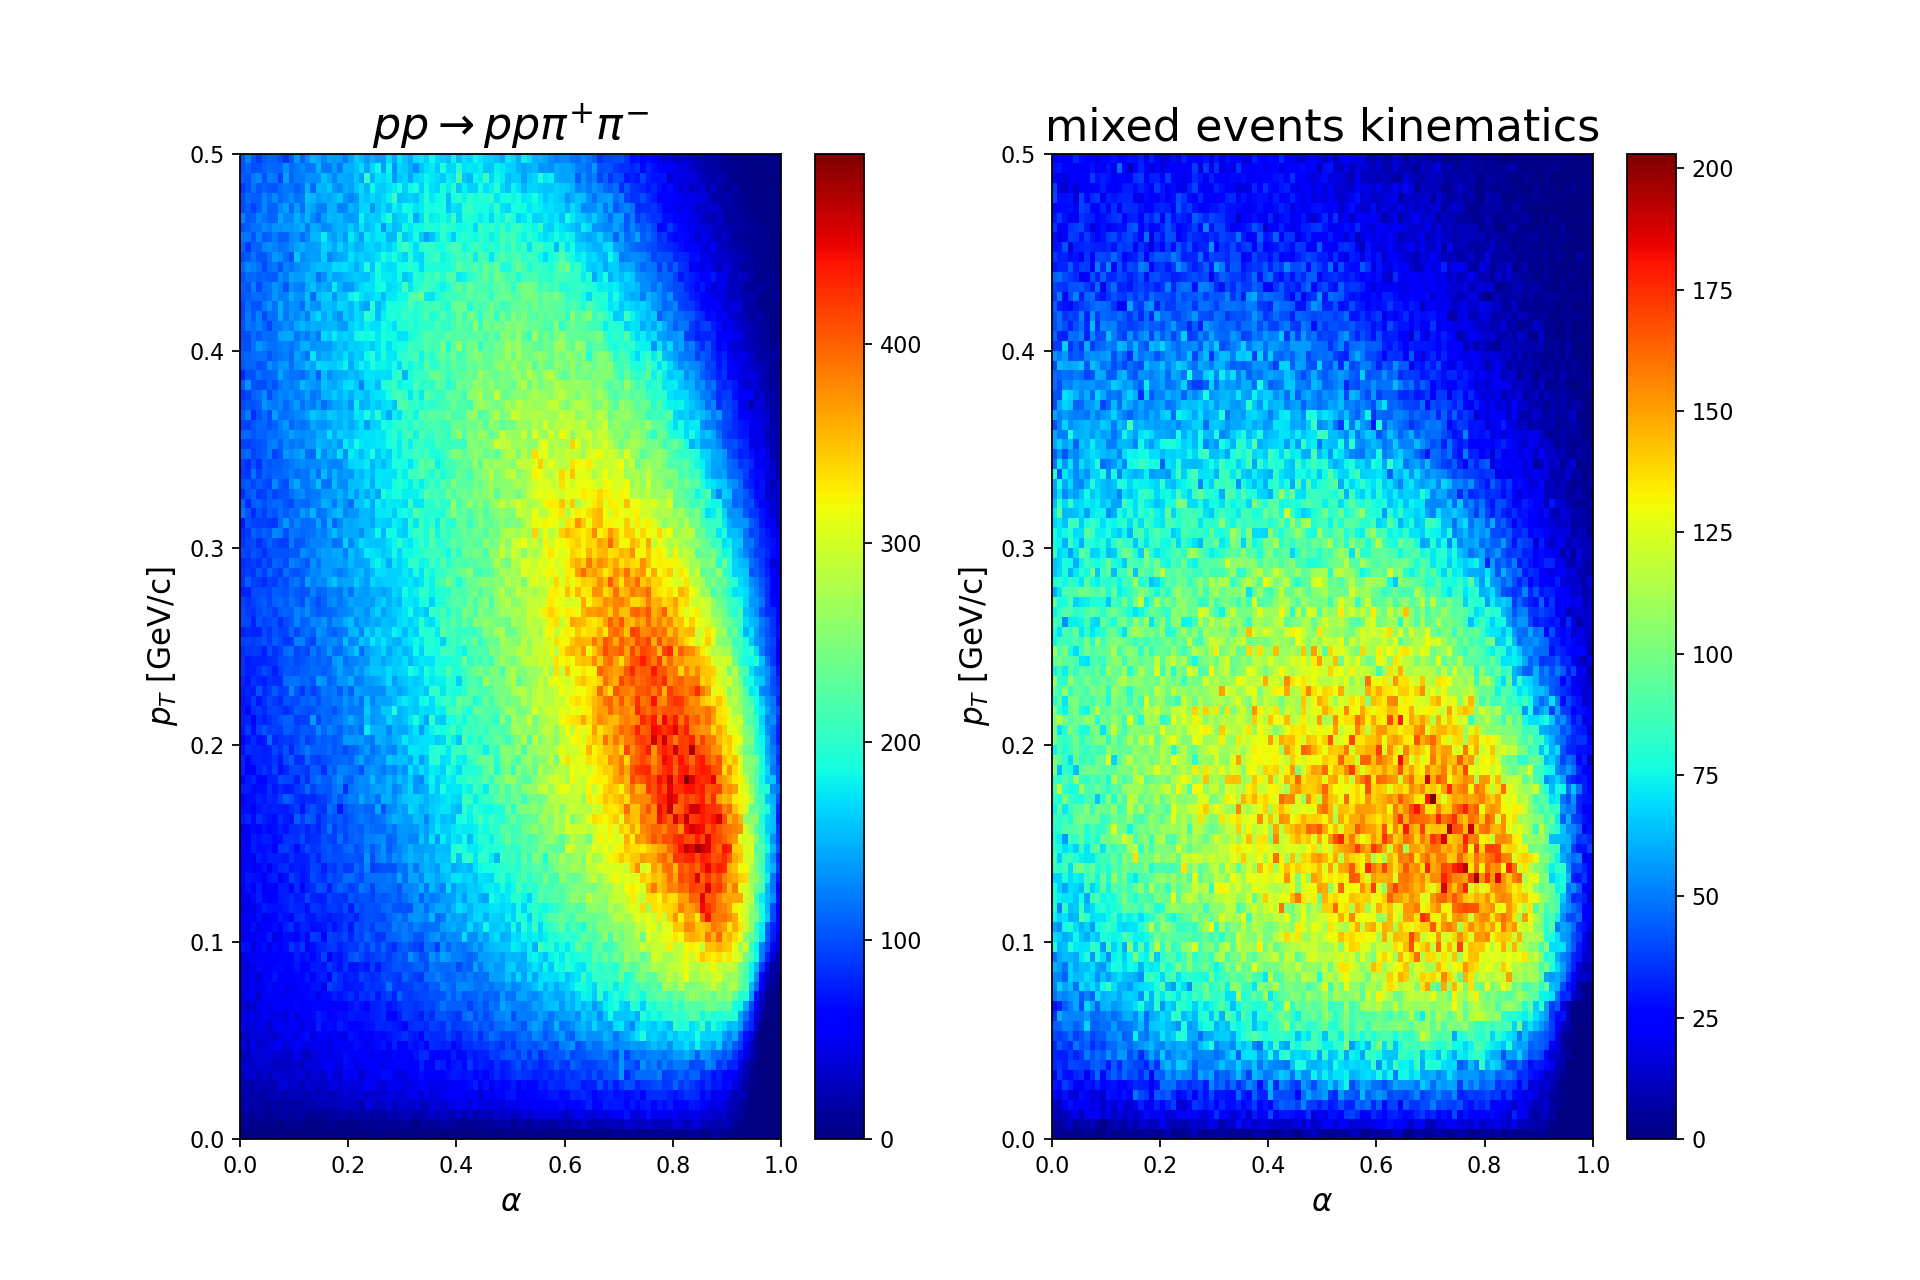

In [14]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

plt.subplot(1, 2, 1)
_ = plt.hist2d(df.loc[df.label==0].alpha, df.loc[df.label==0].q_t, bins=(100, 100), range=[[0, 1], [0, 0.5]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title(r'$pp \rightarrow pp \pi^{+} \pi^{-}$', fontsize=20)
plt.colorbar()


plt.subplot(1, 2, 2)
_ = plt.hist2d(df.loc[df.label==-2].alpha, df.loc[df.label==-2].q_t, bins=(100, 100), range=[[0, 1], [0, 0.5]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title(r'mixed events kinematics', fontsize=20)
plt.colorbar()

<IPython.core.display.Javascript object>


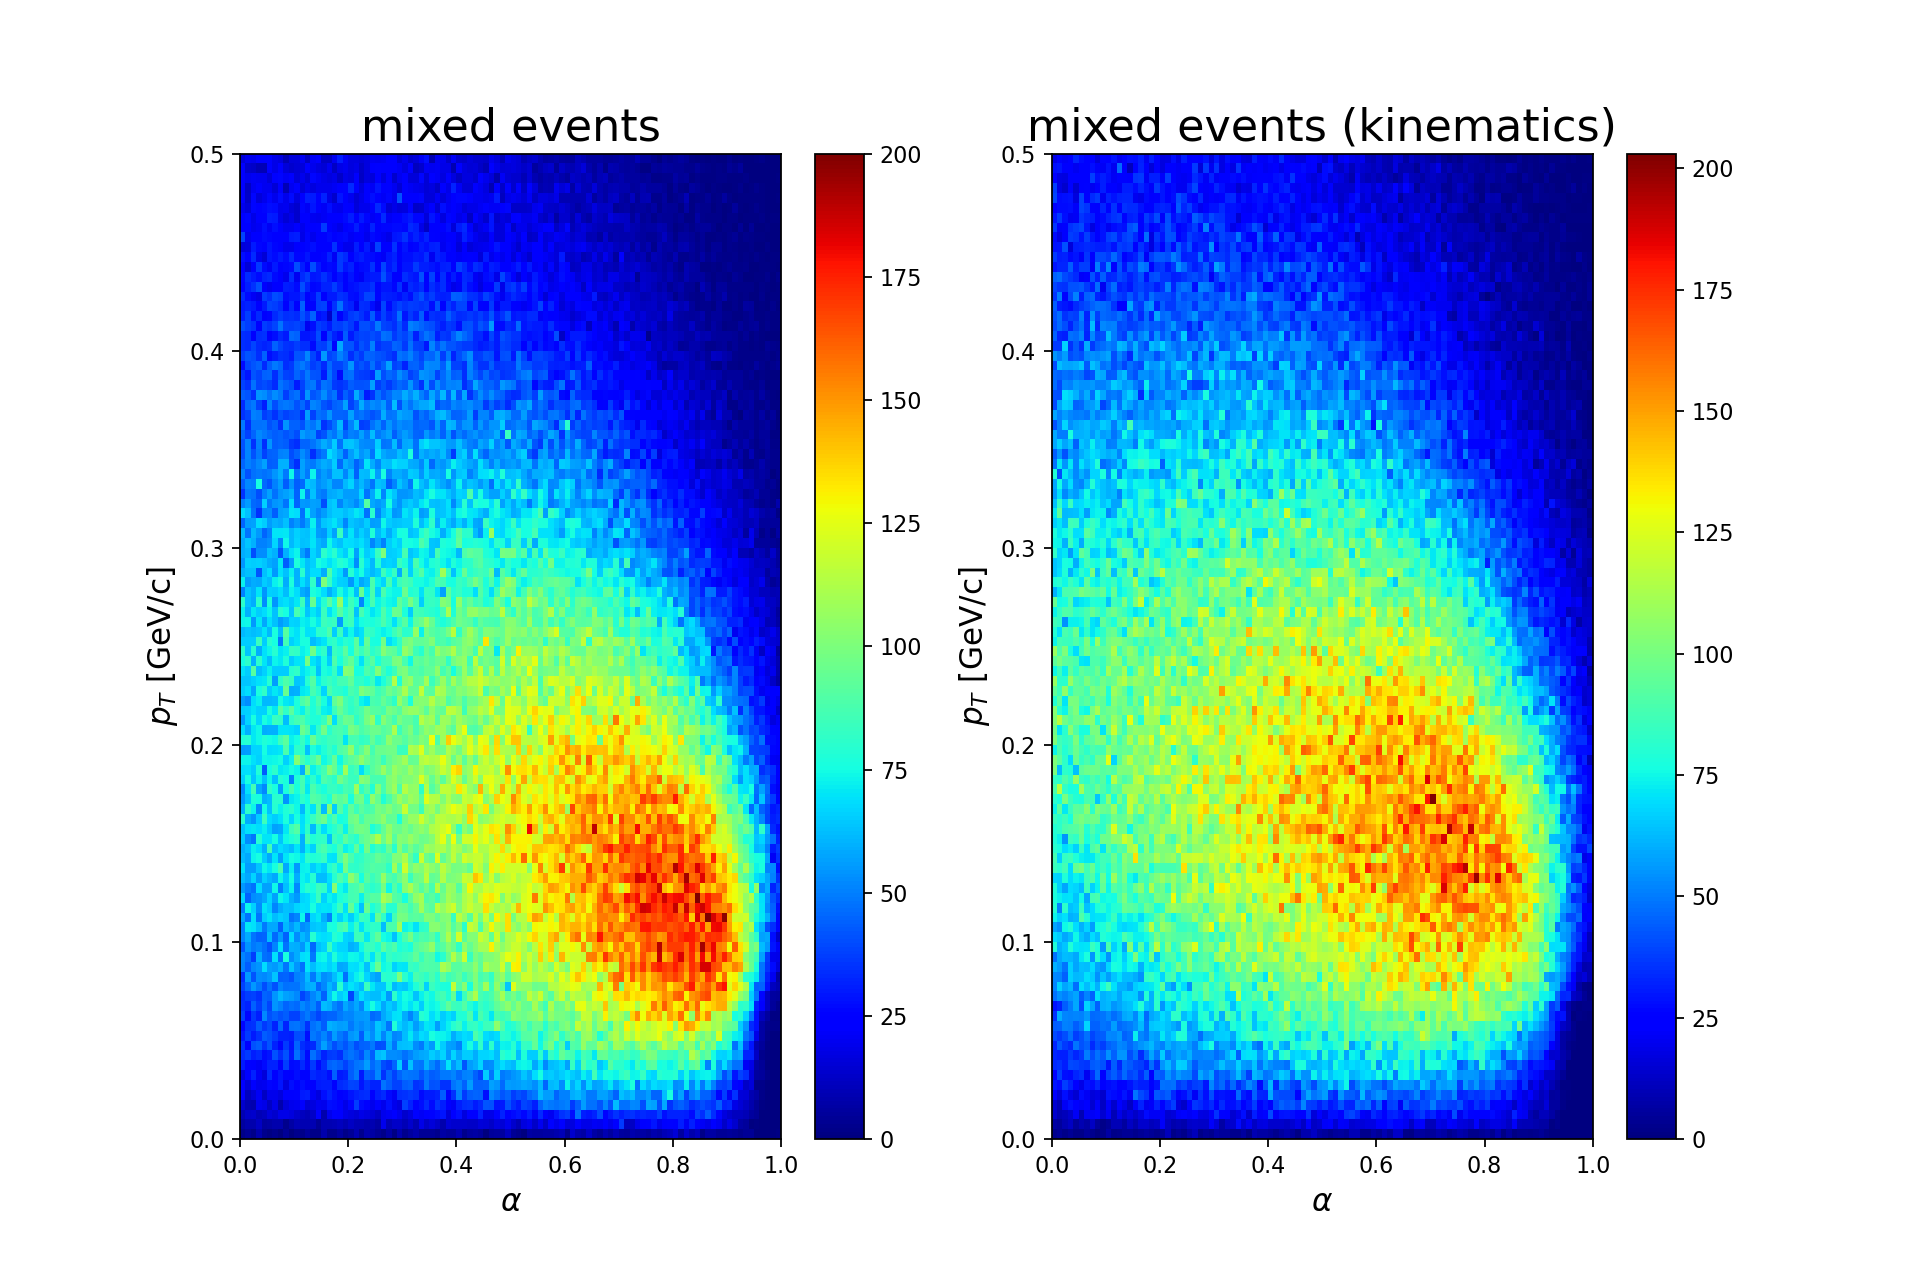

In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

plt.subplot(1, 2, 1)
_ = plt.hist2d(df.loc[df.label==-1].alpha, df.loc[df.label==-1].q_t, bins=(100, 100), range=[[0, 1], [0, 0.5]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title(r'mixed events', fontsize=20)
plt.colorbar()


plt.subplot(1, 2, 2)
_ = plt.hist2d(df.loc[df.label==-2].alpha, df.loc[df.label==-2].q_t, bins=(100, 100), range=[[0, 1], [0, 0.5]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title(r'mixed events (kinematics)', fontsize=20)
plt.colorbar()

<IPython.core.display.Javascript object>


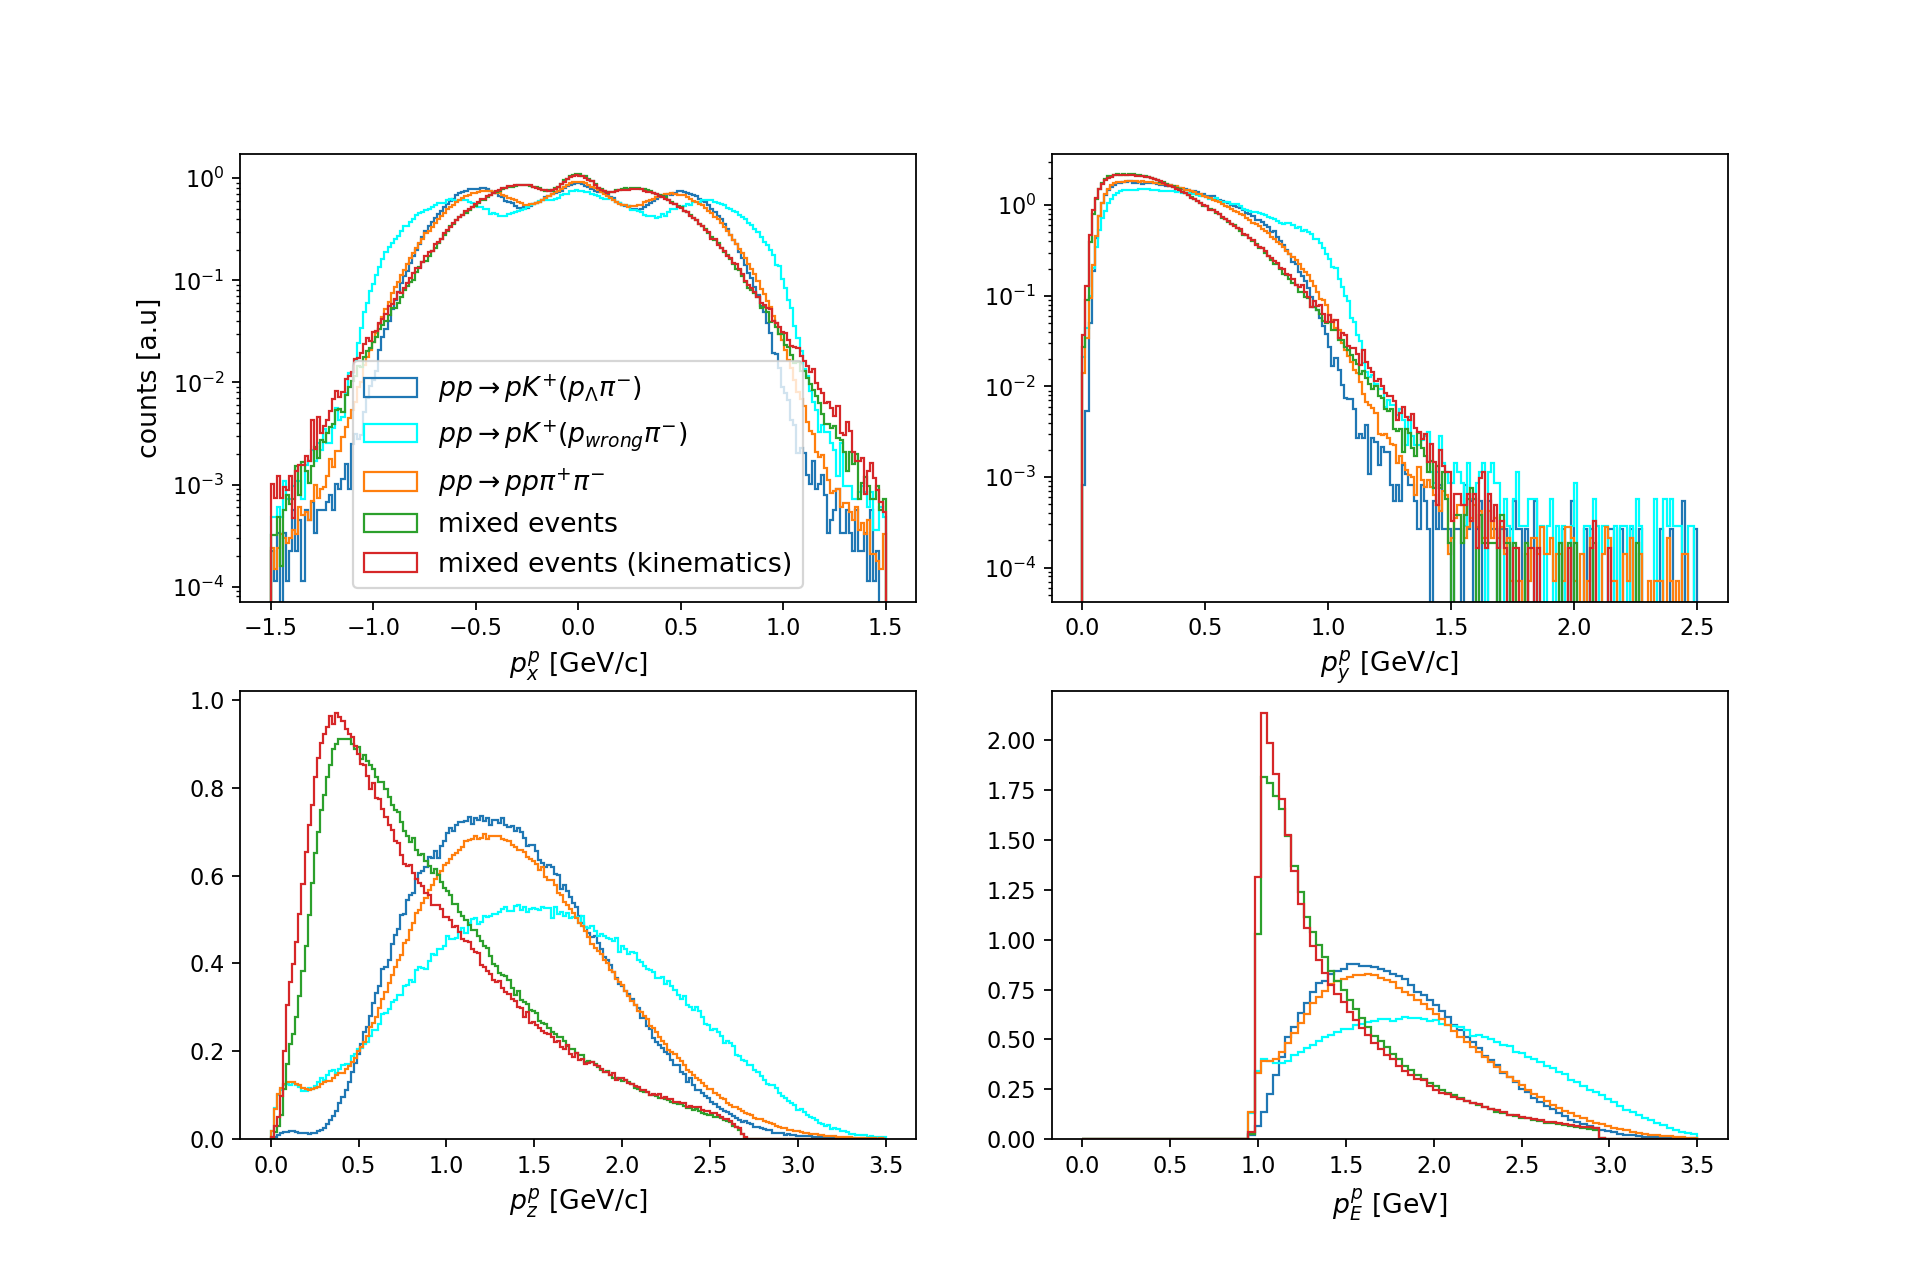

In [16]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

ppx_range = (-1.5, 1.5)
plt.subplot(2, 2, 1)
plt.hist(df.loc[df.label==1].ppx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppx_range, density=True)
plt.hist(df.loc[df.label==2].ppx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppx_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].ppx, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppx_range, density=True)
plt.hist(df.loc[df.label==-1].ppx, histtype='step', bins=200, label='mixed events', range=ppx_range, density=True)
plt.hist(df.loc[df.label==-2].ppx, histtype='step', bins=200, label='mixed events (kinematics)', range=ppx_range, density=True)
plt.xlabel(r'$p^{p}_{x}$ [GeV/c]', fontsize=12)
plt.ylabel('counts [a.u]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12, loc='lower center')

ppy_range = (0, 2.5)
plt.subplot(2, 2, 2)
plt.hist(df.loc[df.label==1].ppy, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppy_range, density=True)
plt.hist(df.loc[df.label==2].ppy, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppy_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].ppy, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppy_range, density=True)
plt.hist(df.loc[df.label==-1].ppy, histtype='step', bins=200, label='mixed events', range=ppy_range, density=True)
plt.hist(df.loc[df.label==-2].ppy, histtype='step', bins=200, label='mixed events (kinematics)', range=ppy_range, density=True)
plt.semilogy()
plt.xlabel(r'$p^{p}_{y}$ [GeV/c]', fontsize=12)

ppz_range = (0, 3.5)
plt.subplot(2, 2, 3)
plt.hist(df.loc[df.label==1].ppz, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppz_range, density=True)
plt.hist(df.loc[df.label==2].ppz, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppz_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].ppz, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppz_range, density=True)
plt.hist(df.loc[df.label==-1].ppz, histtype='step', bins=200, label='mixed events', range=ppz_range, density=True)
plt.hist(df.loc[df.label==-2].ppz, histtype='step', bins=200, label='mixed events (kinematics)', range=ppz_range, density=True)
plt.xlabel(r'$p^{p}_{z}$ [GeV/c]', fontsize=12)

ppe_range = (0, 3.5)
plt.subplot(2, 2, 4)
plt.hist(df.loc[df.label==1].pe, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppe_range, density=True)
plt.hist(df.loc[df.label==2].pe, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=ppe_range, density=True, color='cyan')
plt.hist(df.loc[df.label==0].pe, histtype='step', bins=100, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppe_range, density=True)
plt.hist(df.loc[df.label==-1].pe, histtype='step', bins=100, label='mixed events', range=ppe_range, density=True)
plt.hist(df.loc[df.label==-2].pe, histtype='step', bins=100, label='mixed events (kinematics)', range=ppe_range, density=True)
plt.xlabel(r'$p^{p}_{E}$ [GeV]', fontsize=12)


plt.show()

<IPython.core.display.Javascript object>


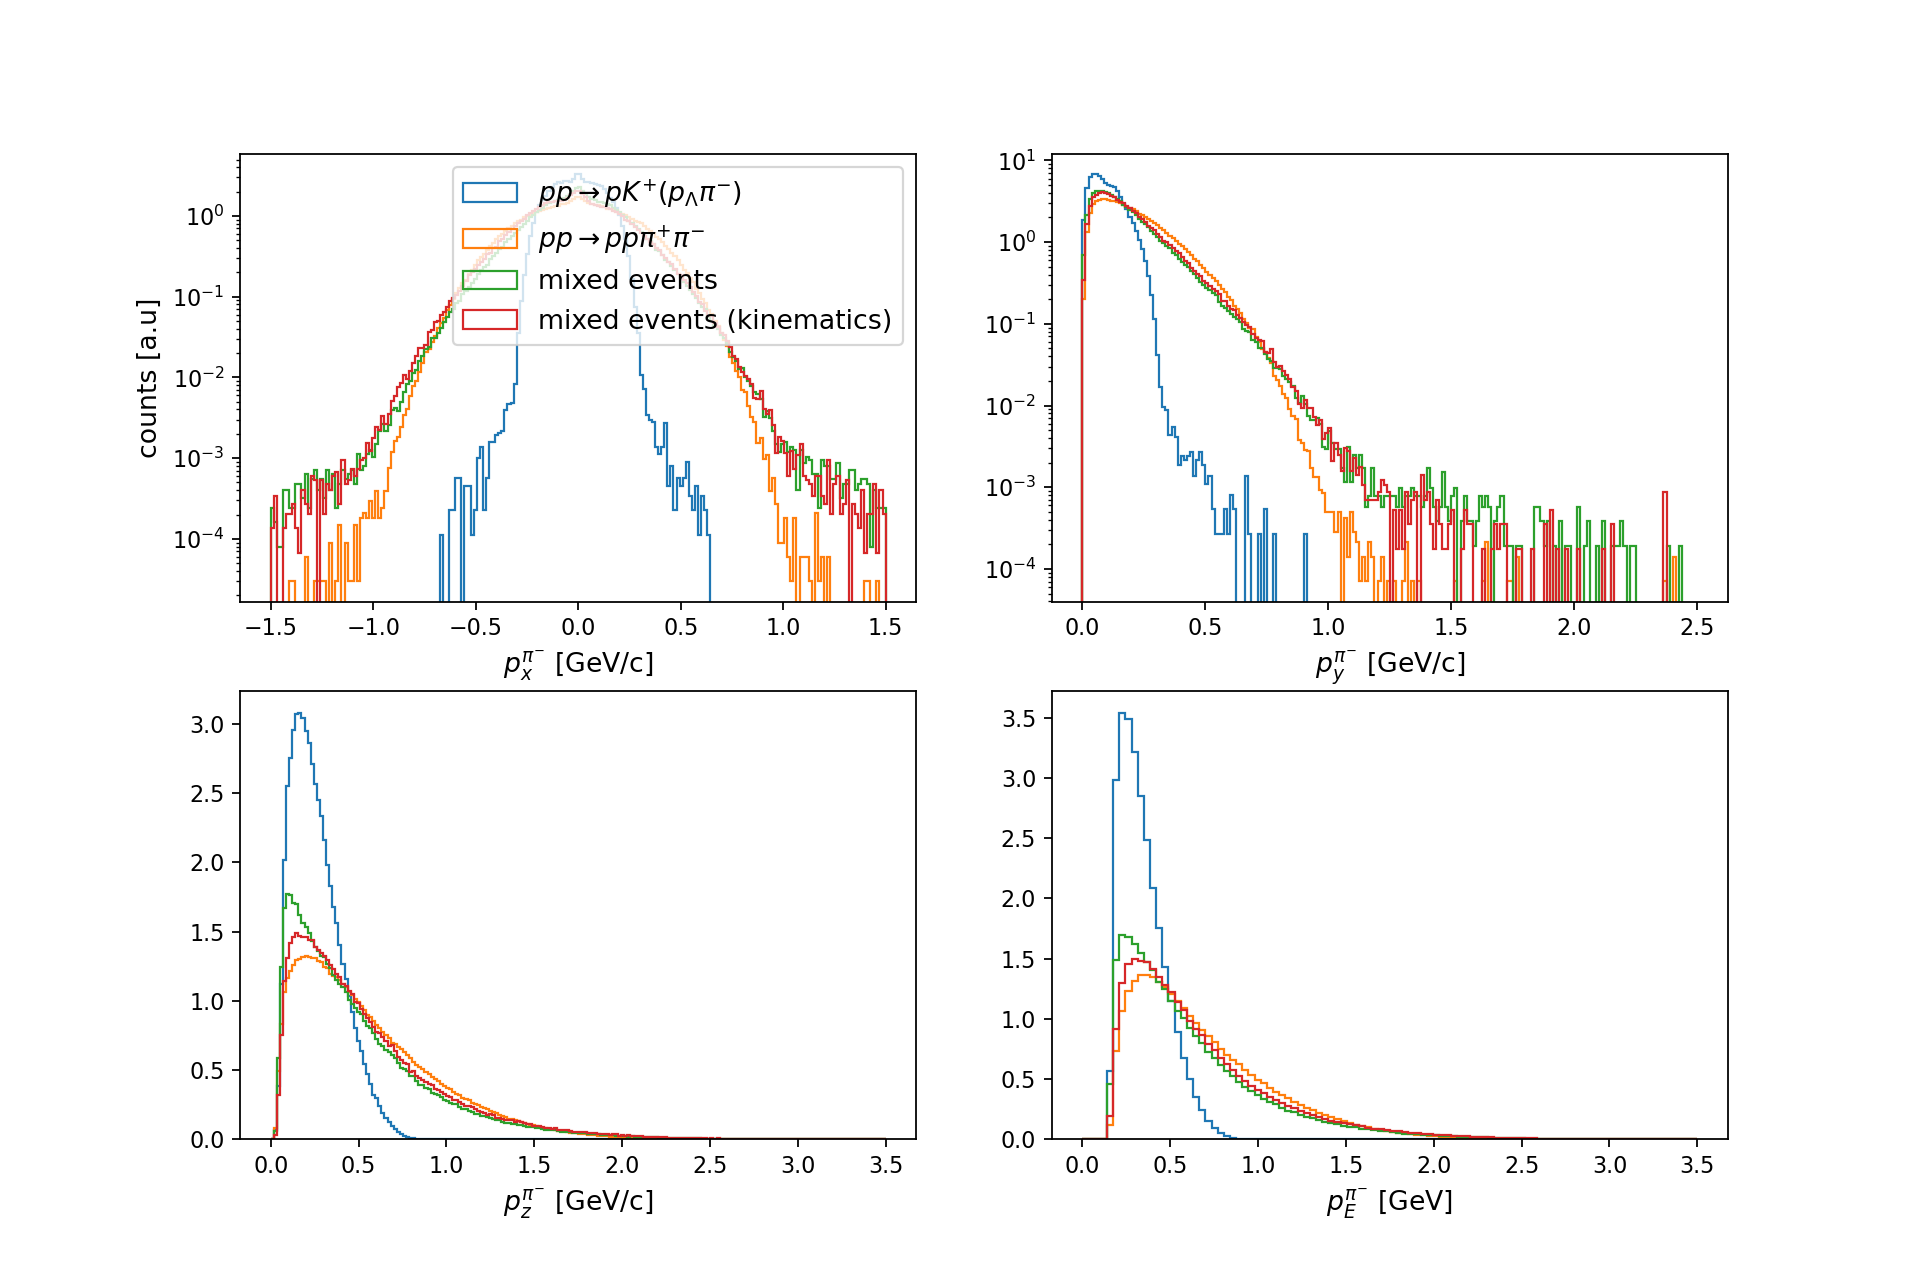

In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

ppx_range = (-1.5, 1.5)
plt.subplot(2, 2, 1)
plt.hist(df.loc[df.label==1].pipx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppx_range, density=True)
plt.hist(df.loc[df.label==0].pipx, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppx_range, density=True)
plt.hist(df.loc[df.label==-1].pipx, histtype='step', bins=200, label='mixed events', range=ppx_range, density=True)
plt.hist(df.loc[df.label==-2].pipx, histtype='step', bins=200, label='mixed events (kinematics)', range=ppx_range, density=True)
plt.xlabel(r'$p^{\pi^{-}}_{x}$ [GeV/c]', fontsize=12)
plt.ylabel('counts [a.u]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

ppy_range = (0, 2.5)
plt.subplot(2, 2, 2)
plt.hist(df.loc[df.label==1].pipy, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppy_range, density=True)
plt.hist(df.loc[df.label==0].pipy, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppy_range, density=True)
plt.hist(df.loc[df.label==-1].pipy, histtype='step', bins=200, label='mixed events', range=ppy_range, density=True)
plt.hist(df.loc[df.label==-2].pipy, histtype='step', bins=200, label='mixed events (kinematics)', range=ppy_range, density=True)
plt.semilogy()
plt.xlabel(r'$p^{\pi^{-}}_{y}$ [GeV/c]', fontsize=12)

ppz_range = (0, 3.5)
plt.subplot(2, 2, 3)
plt.hist(df.loc[df.label==1].pipz, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppz_range, density=True)
plt.hist(df.loc[df.label==0].pipz, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppz_range, density=True)
plt.hist(df.loc[df.label==-1].pipz, histtype='step', bins=200, label='mixed events', range=ppz_range, density=True)
plt.hist(df.loc[df.label==-2].pipz, histtype='step', bins=200, label='mixed events (kinematics)', range=ppz_range, density=True)
plt.xlabel(r'$p^{\pi^{-}}_{z}$ [GeV/c]', fontsize=12)

ppe_range = (0, 3.5)
plt.subplot(2, 2, 4)
plt.hist(df.loc[df.label==1].pie, histtype='step', bins=100, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=ppe_range, density=True)
plt.hist(df.loc[df.label==0].pie, histtype='step', bins=100, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=ppe_range, density=True)
plt.hist(df.loc[df.label==-1].pie, histtype='step', bins=100, label='mixed events', range=ppe_range, density=True)
plt.hist(df.loc[df.label==-2].pie, histtype='step', bins=100, label='mixed events (kinematics)', range=ppe_range, density=True)
plt.xlabel(r'$p^{\pi^{-}}_{E}$ [GeV]', fontsize=12)


plt.show()

<IPython.core.display.Javascript object>


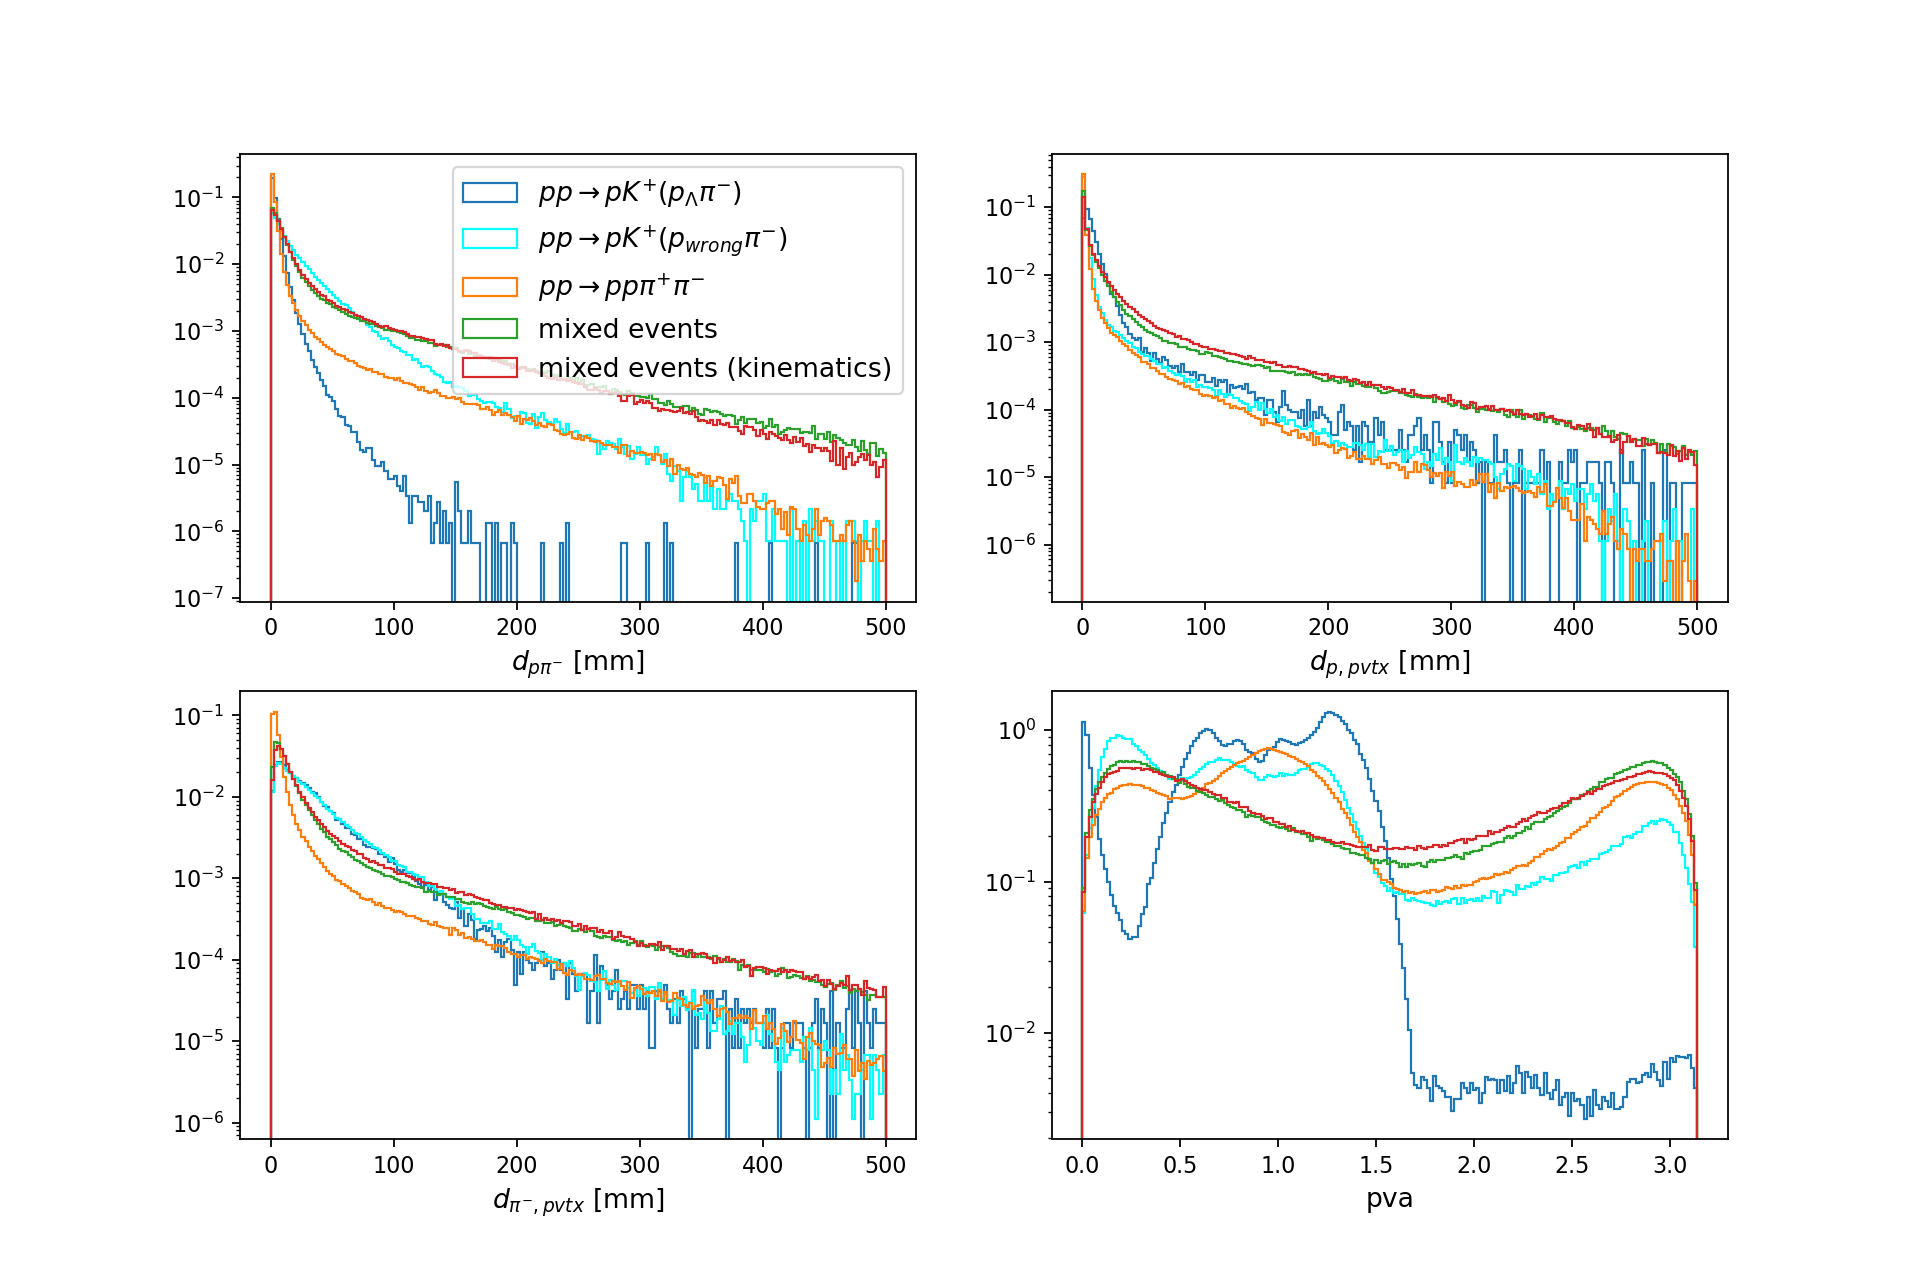

In [18]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

df = train

plt.subplot(2, 2, 1)
plt.hist(df.loc[df.label==1].d_ppi, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,500), density=True)
plt.hist(df.loc[df.label==2].d_ppi, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,500), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_ppi, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,500), density=True)
plt.hist(df.loc[df.label==-1].d_ppi, histtype='step', bins=200, label='mixed events', range=(0,500), density=True)
plt.hist(df.loc[df.label==-2].d_ppi, histtype='step', bins=200, label='mixed events (kinematics)', range=(0,500), density=True)

plt.xlabel(r'$d_{p\pi^{-}}$ [mm]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)


plt.subplot(2, 2, 2)
plt.hist(df.loc[df.label==1].d_p_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,500), density=True)
plt.hist(df.loc[df.label==2].d_p_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,500), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_p_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,500), density=True)
plt.hist(df.loc[df.label==-1].d_p_pvtx, histtype='step', bins=200, label='mixed events', range=(0,500), density=True)
plt.hist(df.loc[df.label==-2].d_p_pvtx, histtype='step', bins=200, label='mixed events (kinematics)', range=(0,500), density=True)
plt.xlabel(r'$d_{p, pvtx}$ [mm]', fontsize=12)
plt.semilogy()

plt.subplot(2, 2, 3)
plt.hist(df.loc[df.label==1].d_pi_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,500), density=True)
plt.hist(df.loc[df.label==2].d_pi_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,500), density=True, color='cyan')
plt.hist(df.loc[df.label==0].d_pi_pvtx, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,500), density=True)
plt.hist(df.loc[df.label==-1].d_pi_pvtx, histtype='step', bins=200, label='mixed events', range=(0,500), density=True)
plt.hist(df.loc[df.label==-2].d_pi_pvtx, histtype='step', bins=200, label='mixed events (kinematics)', range=(0,500), density=True)
plt.xlabel(r'$d_{\pi^{-}, pvtx}$ [mm]', fontsize=12)
plt.semilogy()

plt.subplot(2, 2, 4)
plt.hist(df.loc[df.label==1].pva, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{\Lambda}\pi^{-})$', range=(0,3.14), density=True)
plt.hist(df.loc[df.label==2].pva, histtype='step', bins=200, label=r'$pp \rightarrow p K^{+} (p_{wrong}\pi^{-})$', range=(0,3.14), density=True, color='cyan')
plt.hist(df.loc[df.label==0].pva, histtype='step', bins=200, label=r'$pp \rightarrow pp \pi^{+} \pi^{-}$', range=(0,3.14), density=True)
plt.hist(df.loc[df.label==-1].pva, histtype='step', bins=200, label='mixed events', range=(0,3.14), density=True)
plt.hist(df.loc[df.label==-2].pva, histtype='step', bins=200, label='mixed events (kinematics)', range=(0,3.14), density=True)
plt.xlabel(r'pva', fontsize=12)
plt.semilogy()


plt.show()